# Deep Learning with PyTorch Step-by-Step: A Beginner's Guide

# Chapter 8

In [1]:
%reload_ext autoreload
%autoreload 2

In [71]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import rnn as rnn_utils
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset

In [32]:
from data_generation.square_sequences import generate_sequences
from plots.chapter8 import counter_vs_clock, plot_sequences, plot_data, canonical_contour, hidden_states_contour
from plots.chapter8 import figure8, figure13, figure16, figure17, figure20, figure22, figure25
from stepbystep.v1 import StepByStep

# Sequences

## Data Generation

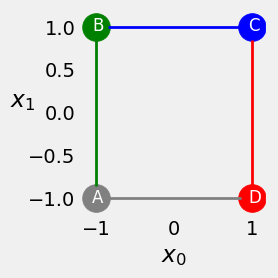

In [5]:
fig = counter_vs_clock(draw_arrows=False)

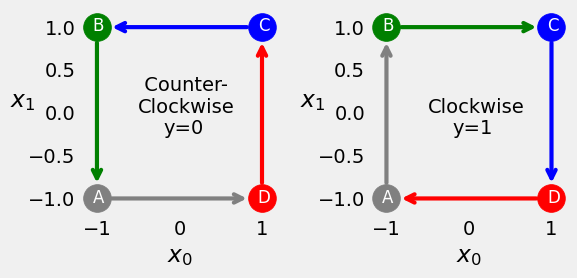

In [6]:
fig = counter_vs_clock()

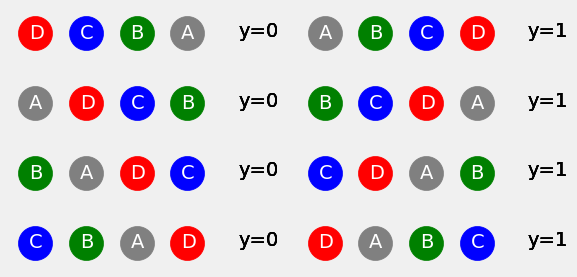

In [8]:
fig = plot_sequences()

In [11]:
points, directions = generate_sequences(n=128, seed=13)

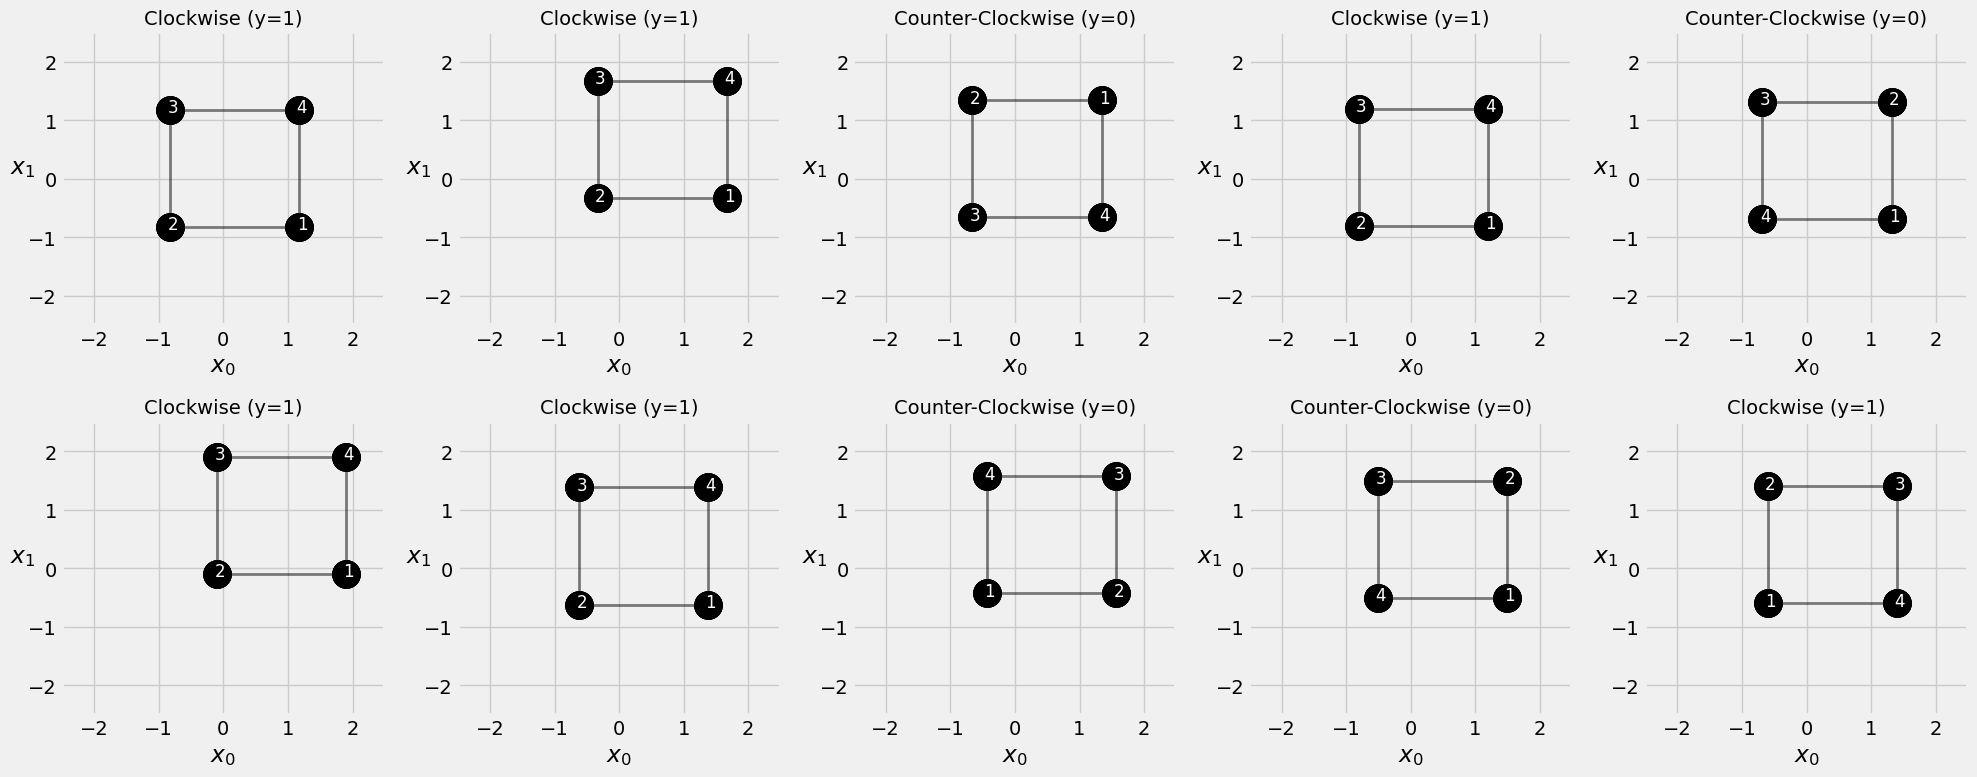

In [15]:
fig = plot_data(points, directions)

## Recurrent Neural Networks (RNNs)

In [3]:
hidden_state = torch.zeros(2)
hidden_state

tensor([0., 0.])

![](images/rnn2.png)

### RNN Cell

![](images/rnn1.png)

$$
\Large
\begin{array}{ccccccc}
\text{RNN}: & \color{#0066CC}{t_h} & \color{#0066CC}{=} & \color{#0066CC}{W_{hh}} & \color{#0066CC}{h_{t-1}} & \color{#0066CC}{+} & \color{#0066CC}{b_{hh}}
\\
& \color{red}{t_x} & \color{red}{=} & \color{red}{W_{ih}} & \color{red}{x_{t}} & \color{red}{+} & \color{red}{b_{ih}}
\\
& \color{#0066CC}{h_t} & \color{#0066CC}{=} & \color{#0066CC}{\text{tanh}} & \color{#0066CC}{(t_h} & \color{#0066CC}{+} & \color{#0066CC}{t_x)}
\end{array}
$$

![](images/rnn_cell_diagram.png)

In [5]:
input_size = 2
hidden_size = 2

torch.manual_seed(19)
rnn_cell = nn.RNNCell(input_size=input_size, hidden_size=hidden_size)
rnn_state = rnn_cell.state_dict()
rnn_state

OrderedDict([('weight_ih',
              tensor([[ 0.6627, -0.4245],
                      [ 0.5373,  0.2294]])),
             ('weight_hh',
              tensor([[-0.4015, -0.5385],
                      [-0.1956, -0.6835]])),
             ('bias_ih', tensor([0.4954, 0.6533])),
             ('bias_hh', tensor([-0.3565, -0.2904]))])

In [6]:
linear_input = nn.Linear(input_size, hidden_size)
linear_hidden = nn.Linear(hidden_size, hidden_size)

with torch.no_grad():
    linear_input.weight = nn.Parameter(rnn_state['weight_ih'])
    linear_input.bias = nn.Parameter(rnn_state['bias_ih'])
    linear_hidden.weight = nn.Parameter(rnn_state['weight_hh'])
    linear_hidden.bias = nn.Parameter(rnn_state['bias_hh'])

In [7]:
initial_hidden = torch.zeros(1, hidden_size)
initial_hidden

tensor([[0., 0.]])

In [8]:
th = linear_hidden(initial_hidden)
th

tensor([[-0.3565, -0.2904]], grad_fn=<AddmmBackward0>)

In [11]:
X = torch.as_tensor(points[0])
X

tensor([[ 1.1767, -0.8233],
        [-0.8233, -0.8233],
        [-0.8233,  1.1767],
        [ 1.1767,  1.1767]], dtype=torch.float64)

In [13]:
X = torch.as_tensor(points[0], dtype=float)
X

tensor([[ 1.1767, -0.8233],
        [-0.8233, -0.8233],
        [-0.8233,  1.1767],
        [ 1.1767,  1.1767]], dtype=torch.float64)

In [14]:
X = torch.as_tensor(points[0], dtype=torch.float32)
X

tensor([[ 1.1767, -0.8233],
        [-0.8233, -0.8233],
        [-0.8233,  1.1767],
        [ 1.1767,  1.1767]])

In [15]:
X = torch.as_tensor(points[0]).float()
X

tensor([[ 1.1767, -0.8233],
        [-0.8233, -0.8233],
        [-0.8233,  1.1767],
        [ 1.1767,  1.1767]])

In [16]:
tx = linear_input(X[0:1])
tx

tensor([[1.6247, 1.0967]], grad_fn=<AddmmBackward0>)

In [17]:
adding = th + tx
adding

tensor([[1.2681, 0.8063]], grad_fn=<AddBackward0>)

In [18]:
torch.tanh(adding)

tensor([[0.8533, 0.6675]], grad_fn=<TanhBackward0>)

In [19]:
rnn_cell(X[0:1])

tensor([[0.8533, 0.6675]], grad_fn=<TanhBackward0>)

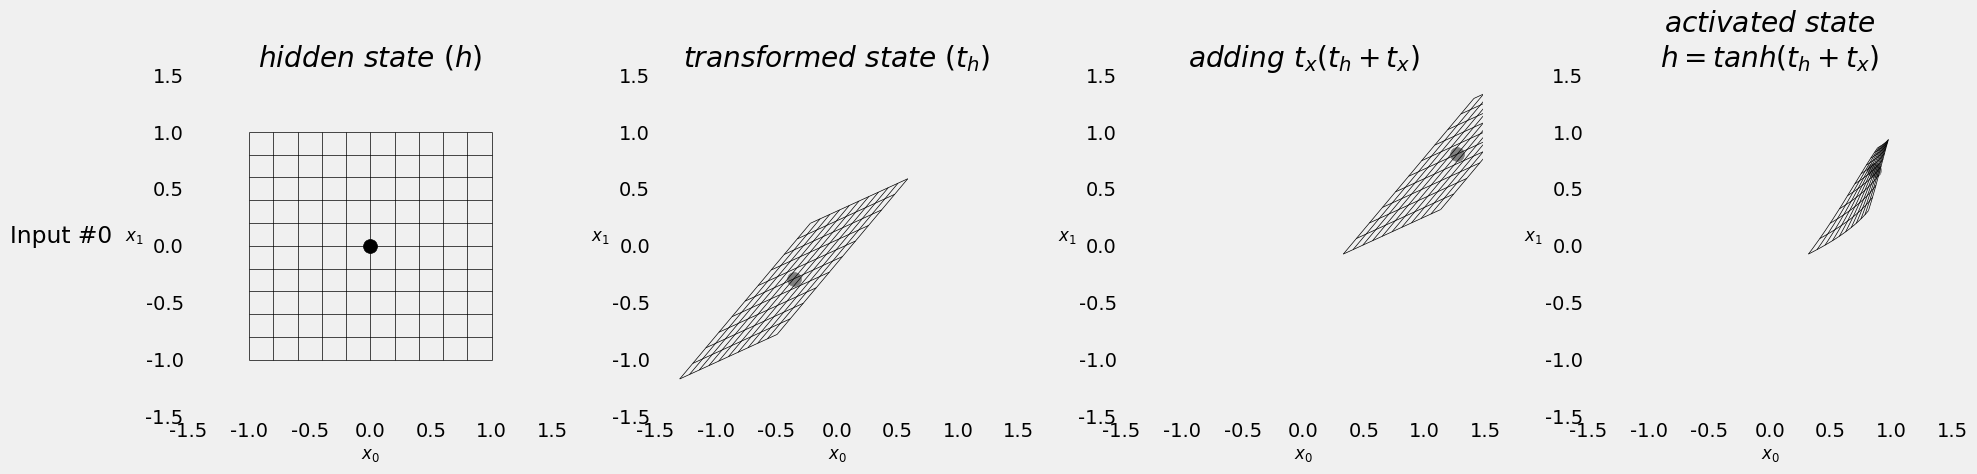

In [21]:
fig = figure8(linear_hidden, linear_input, X)

In [ ]:
# WRONG
rnn_cell(X)

In [22]:
hidden = torch.zeros(1, hidden_size)
for i in range(X.shape[0]):
    out = rnn_cell(X[i:i+1], hidden)
    print(out)
    hidden = out

tensor([[0.8533, 0.6675]], grad_fn=<TanhBackward0>)
tensor([[-0.6407, -0.7121]], grad_fn=<TanhBackward0>)
tensor([[-0.2594,  0.6654]], grad_fn=<TanhBackward0>)
tensor([[0.1636, 0.6967]], grad_fn=<TanhBackward0>)


### RNN Layer

In [23]:
input_size = 2
hidden_size = 2

torch.manual_seed(19)
rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size)
rnn.state_dict()

OrderedDict([('weight_ih_l0',
              tensor([[ 0.6627, -0.4245],
                      [ 0.5373,  0.2294]])),
             ('weight_hh_l0',
              tensor([[-0.4015, -0.5385],
                      [-0.1956, -0.6835]])),
             ('bias_ih_l0', tensor([0.4954, 0.6533])),
             ('bias_hh_l0', tensor([-0.3565, -0.2904]))])

### Shapes

In [26]:
batch = torch.as_tensor(np.array(points[:3])).float()
batch.shape

torch.Size([3, 4, 2])

In [27]:
permuted_batch = batch.permute(1, 0, 2)
permuted_batch.shape

torch.Size([4, 3, 2])

In [28]:
torch.manual_seed(19)
rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size)
out, final_hidden = rnn(permuted_batch)
out.shape, final_hidden.shape

(torch.Size([4, 3, 2]), torch.Size([1, 3, 2]))

In [29]:
(out[-1] == final_hidden).all()

tensor(True)

In [30]:
batch_hidden = final_hidden.permute(1, 0, 2)
batch_hidden.shape

torch.Size([3, 1, 2])

In [31]:
torch.manual_seed(19)
rnn_batch_first = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)
out, final_hidden = rnn_batch_first(batch)
out.shape, final_hidden.shape

(torch.Size([3, 4, 2]), torch.Size([1, 3, 2]))

### Stacked RNN

![](images/stacked_rnn.png)

In [32]:
torch.manual_seed(19)
rnn_stacked = nn.RNN(input_size=2, hidden_size=2, num_layers=2, batch_first=True)
state = rnn_stacked.state_dict()
state

OrderedDict([('weight_ih_l0',
              tensor([[ 0.6627, -0.4245],
                      [ 0.5373,  0.2294]])),
             ('weight_hh_l0',
              tensor([[-0.4015, -0.5385],
                      [-0.1956, -0.6835]])),
             ('bias_ih_l0', tensor([0.4954, 0.6533])),
             ('bias_hh_l0', tensor([-0.3565, -0.2904])),
             ('weight_ih_l1',
              tensor([[-0.6701, -0.5811],
                      [-0.0170, -0.5856]])),
             ('weight_hh_l1',
              tensor([[ 0.1159, -0.6978],
                      [ 0.3241, -0.0983]])),
             ('bias_ih_l1', tensor([-0.3163, -0.2153])),
             ('bias_hh_l1', tensor([ 0.0722, -0.3242]))])

In [33]:
state_list = list(state.items())
state_list

[('weight_ih_l0',
  tensor([[ 0.6627, -0.4245],
          [ 0.5373,  0.2294]])),
 ('weight_hh_l0',
  tensor([[-0.4015, -0.5385],
          [-0.1956, -0.6835]])),
 ('bias_ih_l0', tensor([0.4954, 0.6533])),
 ('bias_hh_l0', tensor([-0.3565, -0.2904])),
 ('weight_ih_l1',
  tensor([[-0.6701, -0.5811],
          [-0.0170, -0.5856]])),
 ('weight_hh_l1',
  tensor([[ 0.1159, -0.6978],
          [ 0.3241, -0.0983]])),
 ('bias_ih_l1', tensor([-0.3163, -0.2153])),
 ('bias_hh_l1', tensor([ 0.0722, -0.3242]))]

In [34]:
rnn_layer0 = nn.RNN(input_size=2, hidden_size=2, batch_first=True)
rnn_layer1 = nn.RNN(input_size=2, hidden_size=2, batch_first=True)

state_list = list(state.items())
rnn_layer0.load_state_dict(dict(state_list[:4]))
rnn_layer1.load_state_dict(dict([(k[:-1] + '0', v) for k, v in state_list[4:]]))

<All keys matched successfully>

In [35]:
x = torch.as_tensor(points[0:1]).float()

In [36]:
out0, h0 = rnn_layer0(x)

In [38]:
out1, h1 = rnn_layer1(out0)

In [39]:
out1, torch.cat([h0, h1])

(tensor([[[-0.8348, -0.7374],
          [ 0.7686, -0.3002],
          [-0.1572, -0.5691],
          [-0.3625, -0.7376]]], grad_fn=<TransposeBackward1>),
 tensor([[[ 0.1636,  0.6967]],
 
         [[-0.3625, -0.7376]]], grad_fn=<CatBackward0>))

In [40]:
out, hidden = rnn_stacked(x)
out, hidden

(tensor([[[-0.8348, -0.7374],
          [ 0.7686, -0.3002],
          [-0.1572, -0.5691],
          [-0.3625, -0.7376]]], grad_fn=<TransposeBackward1>),
 tensor([[[ 0.1636,  0.6967]],
 
         [[-0.3625, -0.7376]]], grad_fn=<StackBackward0>))

In [43]:
out.shape, hidden.shape

(torch.Size([1, 4, 2]), torch.Size([2, 1, 2]))

In [45]:
hidden_permuted = hidden.permute(1, 0, 2)
hidden_permuted

tensor([[[ 0.1636,  0.6967],
         [-0.3625, -0.7376]]], grad_fn=<PermuteBackward0>)

In [46]:
hidden_permuted.shape

torch.Size([1, 2, 2])

In [47]:
(out[:, -1] == hidden.permute(1, 0, 2)[:, -1]).all()

tensor(True)

### Bidirectional RNN

![](images/bidirect_rnn.png)

In [48]:
torch.manual_seed(19)
rnn_bidirect = nn.RNN(input_size=2, hidden_size=2, bidirectional=True, batch_first=True)
state = rnn_bidirect.state_dict()
state

OrderedDict([('weight_ih_l0',
              tensor([[ 0.6627, -0.4245],
                      [ 0.5373,  0.2294]])),
             ('weight_hh_l0',
              tensor([[-0.4015, -0.5385],
                      [-0.1956, -0.6835]])),
             ('bias_ih_l0', tensor([0.4954, 0.6533])),
             ('bias_hh_l0', tensor([-0.3565, -0.2904])),
             ('weight_ih_l0_reverse',
              tensor([[-0.6701, -0.5811],
                      [-0.0170, -0.5856]])),
             ('weight_hh_l0_reverse',
              tensor([[ 0.1159, -0.6978],
                      [ 0.3241, -0.0983]])),
             ('bias_ih_l0_reverse', tensor([-0.3163, -0.2153])),
             ('bias_hh_l0_reverse', tensor([ 0.0722, -0.3242]))])

In [50]:
rnn_forward = nn.RNN(input_size=2, hidden_size=2, batch_first=True)
rnn_reverse = nn.RNN(input_size=2, hidden_size=2, batch_first=True)

state_list = list(state.items())
rnn_forward.load_state_dict(dict(state_list[:4]))
rnn_reverse.load_state_dict(dict([(k[:-8], v) for k, v in state_list[4:]]))

<All keys matched successfully>

In [51]:
x_rev = torch.flip(x, dims=[1])  # N, L, F
x, x_rev

(tensor([[[ 1.1767, -0.8233],
          [-0.8233, -0.8233],
          [-0.8233,  1.1767],
          [ 1.1767,  1.1767]]]),
 tensor([[[ 1.1767,  1.1767],
          [-0.8233,  1.1767],
          [-0.8233, -0.8233],
          [ 1.1767, -0.8233]]]))

In [52]:
out, hidden = rnn_forward(x)
out_rev, hidden_rev = rnn_reverse(x_rev)
out_rev_back = torch.flip(out_rev, dims=[1])

In [54]:
out, out_rev_back, hidden, hidden_rev

(tensor([[[ 0.8533,  0.6675],
          [-0.6407, -0.7121],
          [-0.2594,  0.6654],
          [ 0.1636,  0.6967]]], grad_fn=<TransposeBackward1>),
 tensor([[[-0.4668,  0.2006],
          [ 0.8899,  0.0787],
          [ 0.1064, -0.8927],
          [-0.9374, -0.8478]]], grad_fn=<FlipBackward0>),
 tensor([[[0.1636, 0.6967]]], grad_fn=<StackBackward0>),
 tensor([[[-0.4668,  0.2006]]], grad_fn=<StackBackward0>))

In [55]:
torch.cat([out, out_rev_back], dim=2), torch.cat([hidden, hidden_rev])

(tensor([[[ 0.8533,  0.6675, -0.4668,  0.2006],
          [-0.6407, -0.7121,  0.8899,  0.0787],
          [-0.2594,  0.6654,  0.1064, -0.8927],
          [ 0.1636,  0.6967, -0.9374, -0.8478]]], grad_fn=<CatBackward0>),
 tensor([[[ 0.1636,  0.6967]],
 
         [[-0.4668,  0.2006]]], grad_fn=<CatBackward0>))

In [56]:
out, hidden = rnn_bidirect(x)
out, hidden

(tensor([[[ 0.8533,  0.6675, -0.4668,  0.2006],
          [-0.6407, -0.7121,  0.8899,  0.0787],
          [-0.2594,  0.6654,  0.1064, -0.8927],
          [ 0.1636,  0.6967, -0.9374, -0.8478]]], grad_fn=<TransposeBackward1>),
 tensor([[[ 0.1636,  0.6967]],
 
         [[-0.4668,  0.2006]]], grad_fn=<StackBackward0>))

In [60]:
out[:, -1]

tensor([[ 0.1636,  0.6967, -0.9374, -0.8478]], grad_fn=<SelectBackward0>)

In [57]:
hidden.permute(1, 0, 2)

tensor([[[ 0.1636,  0.6967],
         [-0.4668,  0.2006]]], grad_fn=<PermuteBackward0>)

In [58]:
hidden.permute(1, 0, 2).view(1, -1)

tensor([[ 0.1636,  0.6967, -0.4668,  0.2006]], grad_fn=<ViewBackward0>)

In [59]:
out[:, -1] == hidden.permute(1, 0, 2).view(1, -1)

tensor([[ True,  True, False, False]])

## Square Model

### Data Generation

In [27]:
test_points, test_directions = generate_sequences(seed=19)

### Data Preparation

In [28]:
train_data = TensorDataset(torch.as_tensor(points).float(), torch.as_tensor(directions).view(-1, 1).float())
test_data = TensorDataset(torch.as_tensor(test_points).float(), torch.as_tensor(test_directions).view(-1, 1).float())

train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=16)

### Model Configuration

In [34]:
class SquareModel(nn.Module):
    def __init__(self, n_inputs, hidden_size, n_outputs):
        super(SquareModel, self).__init__()
        self.n_inputs = n_inputs
        self.hidden_size = hidden_size
        self.n_outputs = n_outputs
        self.hidden = None
        # Simple RNN
        self.basic_rnn = nn.RNN(input_size=self.n_inputs, hidden_size=self.hidden_size, batch_first=True)
        # Classifier to produce as many logits as outputs
        self.classifier = nn.Linear(self.hidden_size, self.n_outputs)

    def forward(self, x):
        # x is batch first (N, L, F)
        # output is (N, L, H)
        # final hidden state is (1, N, H)
        batch_first_output, self.hidden = self.basic_rnn(x)

        # only last item in sequence (N, 1, H)
        last_output = batch_first_output[:, -1]
        # classifier will output (N, 1, n_outputs)
        out = self.classifier(last_output)

        # final output is (N, n_outputs)
        return out.view(-1, self.n_outputs)

In [35]:
torch.manual_seed(21)
model = SquareModel(n_inputs=2, hidden_size=2, n_outputs=1)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

### Model Training

In [36]:
sbs_rnn = StepByStep(model, loss_fn, optimizer)
sbs_rnn.set_loaders(train_loader, test_loader)
sbs_rnn.train(100)

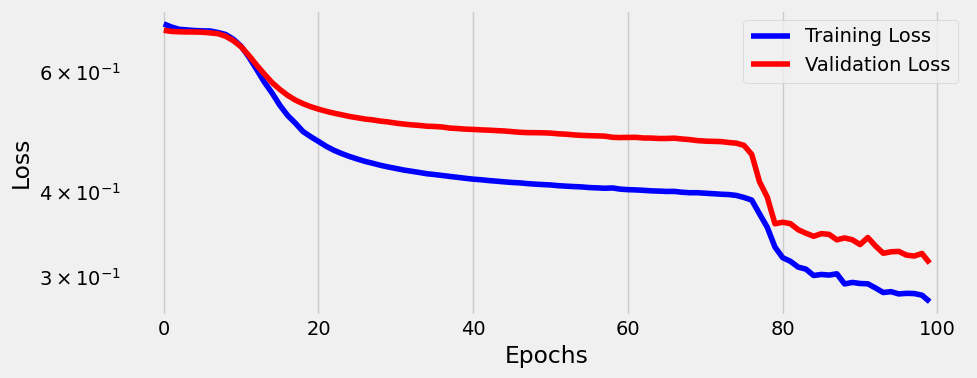

In [72]:
fig = sbs_rnn.plot_losses()

In [73]:
StepByStep.loader_apply(test_loader, sbs_rnn.correct)

tensor([[56, 57],
        [50, 71]])

In [74]:
(56 + 50) / (57 + 71)

0.828125

## Visualizing the Model

### Transformed Inputs

In [75]:
state = model.basic_rnn.state_dict()
state['weight_ih_l0'], state['bias_ih_l0']

(tensor([[-0.4448, -1.8874],
         [-2.4196, -1.9840]], device='cuda:0'),
 tensor([0.0324, 0.0598], device='cuda:0'))

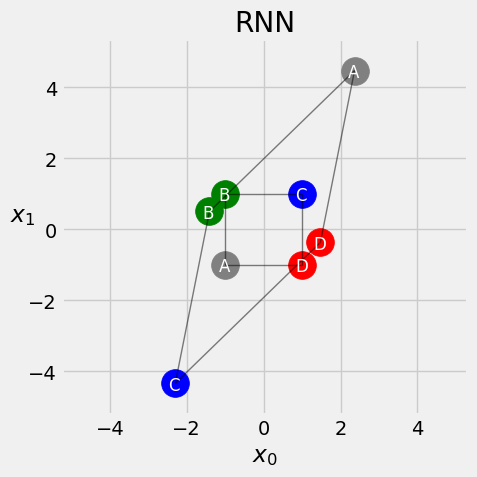

In [77]:
fig = figure13(model.basic_rnn)

### Hidden States

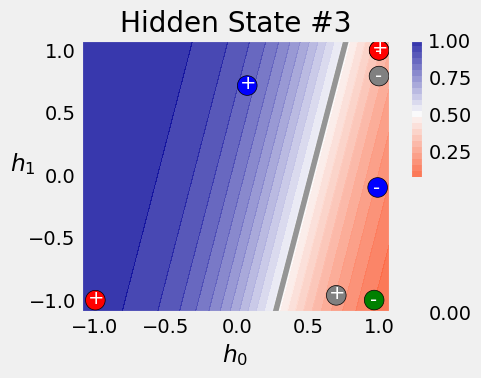

In [81]:
fig = canonical_contour(model)

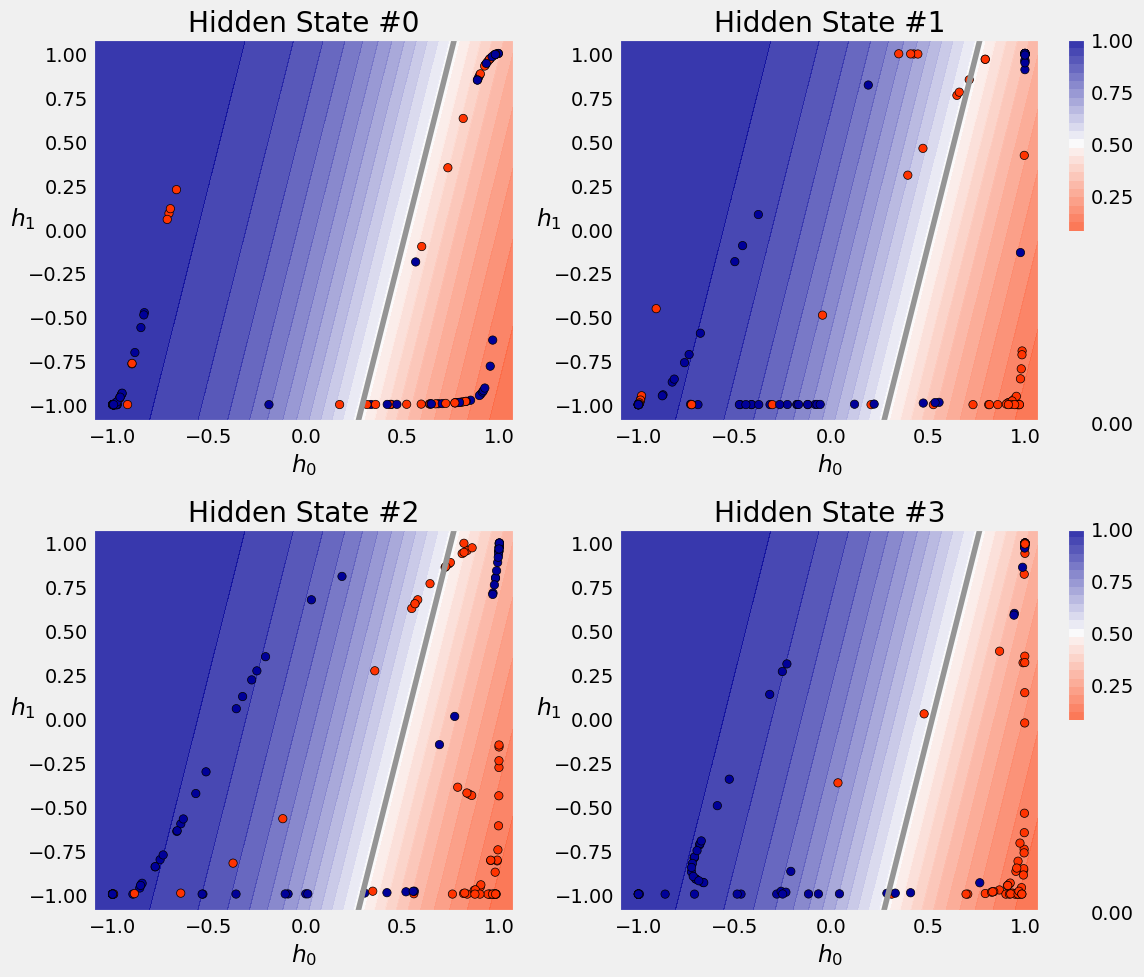

In [83]:
fig = hidden_states_contour(model, points, directions)

### The Journey of a Hidden State

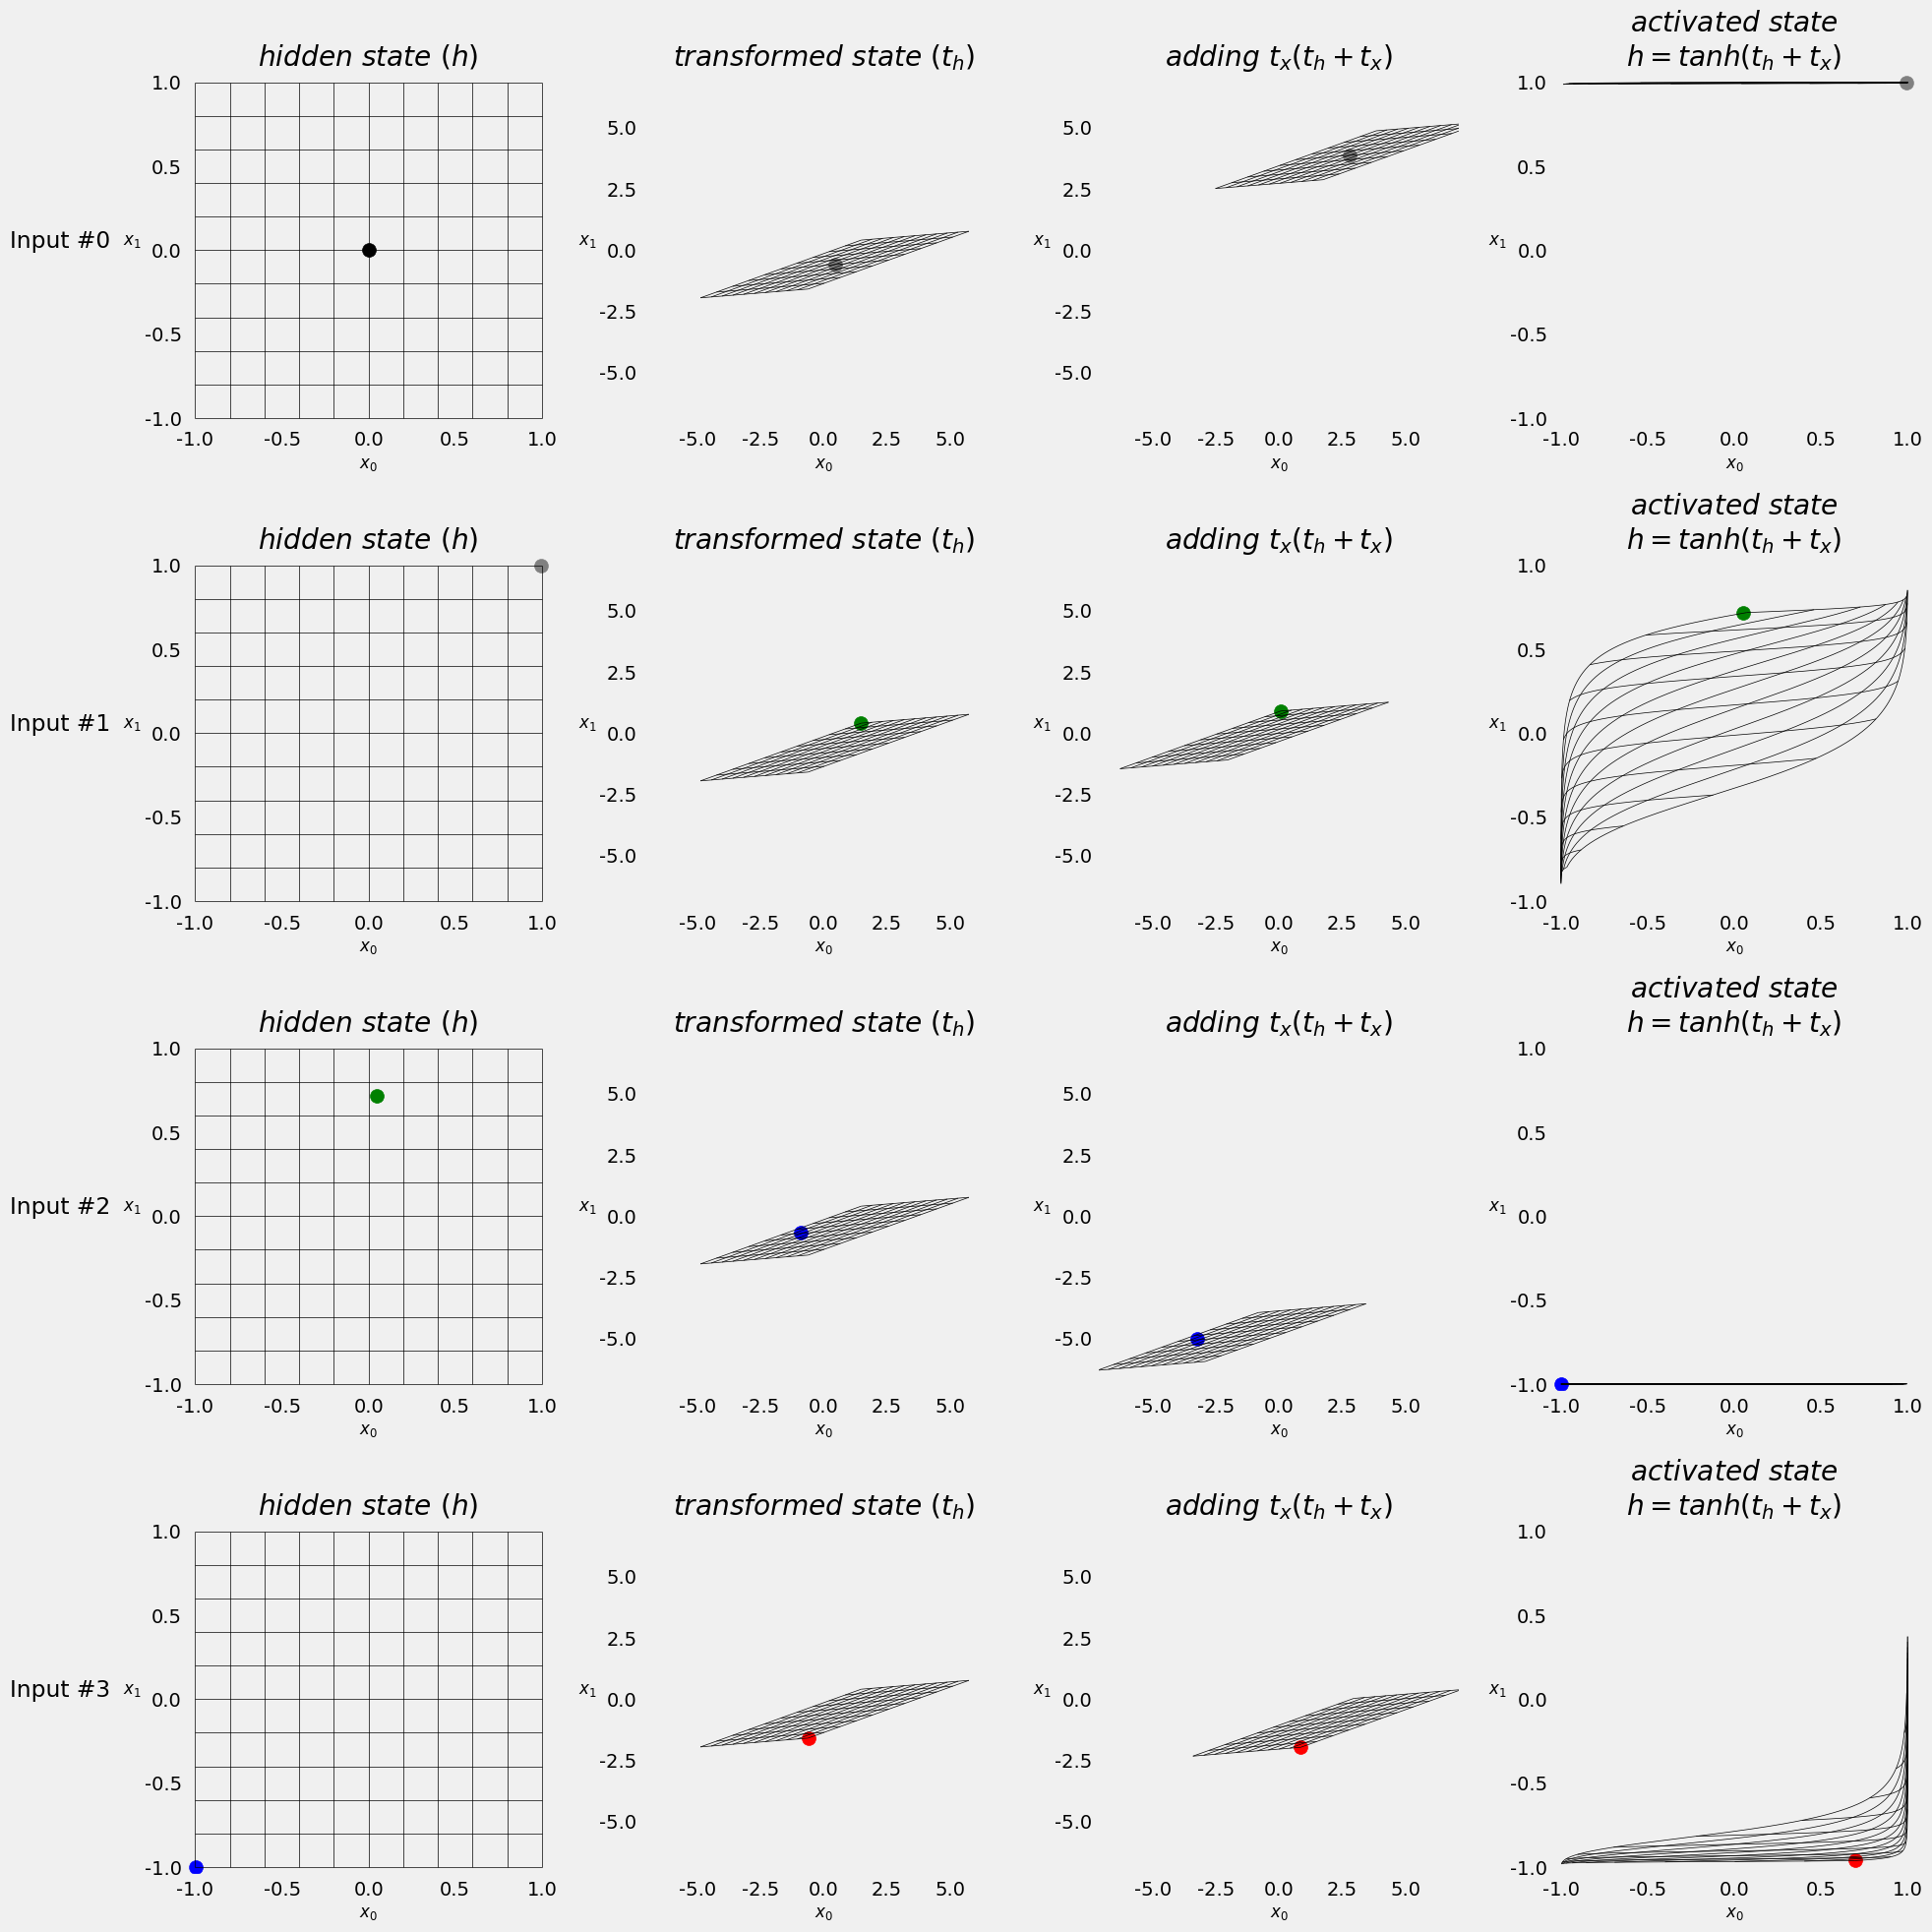

In [85]:
fig = figure16(model.basic_rnn)

In [86]:
square = torch.tensor([[-1, -1], [-1, 1], [1, 1], [1, -1]]).float().view(1, 4, 2)
model(square.to(sbs_rnn.device))
model.hidden

tensor([[[ 0.6983, -0.9612]]], device='cuda:0', grad_fn=<CudnnRnnBackward0>)

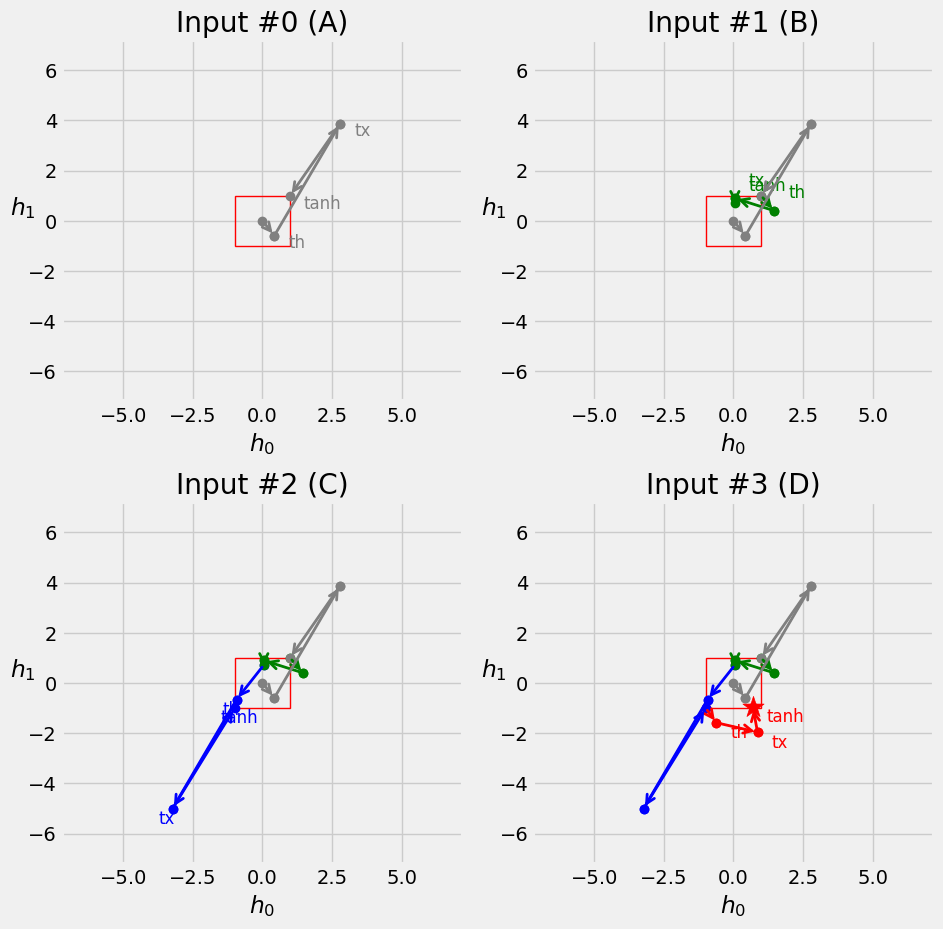

In [88]:
fig = figure17(model.basic_rnn)

## Gated Recurrent Units (GRUs)

$$
\Large
\begin{array}{rcl}
h_{\text{new}} & = & \text{tanh}(t_h+t_x)
\\
h' & = & h_{\text{new}} * (1 - z) + h_{\text{old}} * z
\end{array}
$$

$$
\Large
h_{\text{new}} = \text{tanh}(r*t_h + t_x)
$$

$$
\Large
h' = \text{tanh}(r*t_h + t_x) * (1-z) + h*z
$$

### GRU Cell

$$
\Large
\begin{array}{ccl}
\text{RNN}: \ h' & = & \text{tanh}(t_h+t_x)
\\
\text{GRU}: \ h' & = & \underbrace{\underbrace{\text{tanh}(\textcolor{red}{r}*t_{hn}+t_{xn})}_{n}*\textcolor{#0066CC}{(1-z)} + \color{gray}{h}*\textcolor{#0066CC}{z}}_{\text{weighted average of }n\text{ and }h}
\end{array}
$$

$$
\Large
\begin{array}{ccc}
\textcolor{red}{r(eset gate)} & \textcolor{red}{=} & \textcolor{red}{\sigma(t_{hr} + t_{xr})} 
\\
\textcolor{#0066CC}{z(update gate)} & \textcolor{#0066CC}{=} & \textcolor{#0066CC}{\sigma(t_{hz} + t_{xz})} 
\\
n & = & tanh(\textcolor{red}{r} * t_{hn} + t_{xn})
\end{array}
$$

$$
\Large
\begin{array}{ccccccc}
\color{red}{r \ (hidden)} & \color{red}{:} & \color{red}{t_{hr}} & \color{red}{=} & \color{red}{W_{hr} \ h} & \color{red}{+} & \color{red}{b_{hr}}
\\
\color{red}{r \ (input)} & \color{red}{:} & \color{red}{t_{xr}} & \color{red}{=} & \color{red}{W_{ir} \ x} & \color{red}{+} & \color{red}{b_{ir}}
\\
\color{#0066CC}{z \ (hidden)} & \color{#0066CC}{:} & \color{#0066CC}{t_{hz}} & \color{#0066CC}{=} & \color{#0066CC}{W_{hz} \ h} & \color{#0066CC}{+} & \color{#0066CC}{b_{hz}}
\\
\color{#0066CC}{z \ (input)} & \color{#0066CC}{:} & \color{#0066CC}{t_{xz}} & \color{#0066CC}{=} & \color{#0066CC}{W_{iz} \ x} & \color{#0066CC}{+} & \color{#0066CC}{b_{iz}}
\\
n \ (hidden) & : & t_{hn} &  =  & W_{hn} \ h & + & b_{hn}
\\
n \ (input) & : & t_{xn} &  =  & W_{in} \ x & + & b_{in}
\end{array}
$$

<img src="images/gru_cell.png" width="60%" height="60%">

In [23]:
n_features = 2
hidden_dim = 2

torch.manual_seed(17)
gru_cell = nn.GRUCell(input_size=n_features, hidden_size=hidden_dim)
gru_state = gru_cell.state_dict()
gru_state

OrderedDict([('weight_ih',
              tensor([[-0.0930,  0.0497],
                      [ 0.4670, -0.5319],
                      [-0.6656,  0.0699],
                      [-0.1662,  0.0654],
                      [-0.0449, -0.6828],
                      [-0.6769, -0.1889]])),
             ('weight_hh',
              tensor([[-0.4167, -0.4352],
                      [-0.2060, -0.3989],
                      [-0.7070, -0.5083],
                      [ 0.1418,  0.0930],
                      [-0.5729, -0.5700],
                      [-0.1818, -0.6691]])),
             ('bias_ih',
              tensor([-0.4316,  0.4019,  0.1222, -0.4647, -0.5578,  0.4493])),
             ('bias_hh',
              tensor([-0.6800,  0.4422, -0.3559, -0.0279,  0.6553,  0.2918]))])

In [6]:
Wx, bx = gru_state['weight_ih'], gru_state['bias_ih']
Wh, bh = gru_state['weight_hh'], gru_state['bias_hh']

print(Wx.shape, Wh.shape)
print(bx.shape, bh.shape)

torch.Size([6, 2]) torch.Size([6, 2])
torch.Size([6]) torch.Size([6])


$$
\Large
\begin{align}
W_{xr} & =
\begin{cases}
\begin{array}{rr}
-0.0930, & 0.0497,
\\
0.4670, & -0.5319,
\end{array}
\end{cases} \nonumber
\\
W_{xz} & =
\begin{cases}
\begin{array}{rr}
-0.6656, & 0.0699,
\\
-0.1662, & 0.0654,
\end{array}
\end{cases} \nonumber
\\
W_{xn} & =
\begin{cases}
\begin{array}{rr}
-0.0449, & -0.6828,
\\
-0.6769, & -0.1889,
\end{array}
\end{cases} \nonumber
\end{align}
$$

$$
\Large
\underbrace{-0.4316,  0.4019}_{b_{xr}}, 
\underbrace{0.1222, -0.4647}_{b_{xz}}, 
\underbrace{-0.5578,  0.4493}_{b_{xn}}
$$

In [11]:
W_xr, W_xz, W_xn = Wx.split(hidden_dim, dim=0)
print(W_xr.numpy(), W_xz.numpy(), W_xn.numpy(), sep=',\n')

b_xr, b_xz, b_xn = bx.split(hidden_dim, dim=0)
print(b_xr.numpy(), b_xz.numpy(), b_xn.numpy(), sep=', ')

W_hr, W_hz, W_hn = Wh.split(hidden_dim, dim=0)
print(W_hr.numpy(), W_hz.numpy(), W_hn.numpy(), sep=',\n')

b_hr, b_hz, b_hn = bh.split(hidden_dim, dim=0)
print(b_hr.numpy(), b_hz.numpy(), b_hn.numpy(), sep=', ')

[[-0.09299693  0.04965244]
 [ 0.46698564 -0.53193724]],
[[-0.66564053  0.06985663]
 [-0.16618267  0.0654211 ]],
[[-0.04486127 -0.68284917]
 [-0.6768686  -0.1889009 ]]
[-0.43164796  0.40188766], [ 0.12215219 -0.46473247], [-0.5577969  0.4492511]
[[-0.4166978  -0.4352161 ]
 [-0.20599432 -0.3988804 ]],
[[-0.7069572  -0.5083179 ]
 [ 0.14182186  0.0930218 ]],
[[-0.57290494 -0.56999516]
 [-0.18181518 -0.6691437 ]]
[-0.6800008  0.4422237], [-0.35588545 -0.02794665], [0.655336  0.2917871]


In [12]:
Wx.size()

torch.Size([6, 2])

In [5]:
def linear_layers(Wx, bx, Wh, bh):
    hidden_dim, n_features = Wx.size()
    lin_input = nn.Linear(n_features, hidden_dim)
    lin_input.load_state_dict({'weight': Wx, 'bias': bx})
    lin_hidden = nn.Linear(hidden_dim, hidden_dim)
    lin_hidden.load_state_dict({'weight': Wh, 'bias': bh})
    return lin_input, lin_hidden

In [ ]:
r_input, r_hidden = linear_layers(W_xr, b_xr, W_hr, b_hr)  # reset gate - red
z_input, z_hidden = linear_layers(W_xz, b_xz, W_hz, b_hz)  # update gate - blue
n_input, n_hidden = linear_layers(W_xn, b_xn, W_hn, b_hn)  # candidate state - black

In [15]:
def reset_gate(h, x):
    t_hr = r_hidden(h)
    t_xr = r_input(x)
    r = torch.sigmoid(t_hr + t_xr)
    return r  # red

def update_gate(h, x):
    t_hz = z_hidden(h)
    t_xz = z_input(x)
    z = torch.sigmoid(t_hz + t_xz)
    return z  # blue

def candidate_n(h, x, r):
    t_hn = n_hidden(h)
    t_xn = n_input(x)
    n = torch.tanh(r * t_hn + t_xn)
    return n  # black

In [18]:
initial_hidden = torch.zeros(1, hidden_dim)
x = torch.as_tensor(points[0]).float()
first_corner = x[0:1]

In [19]:
r = reset_gate(initial_hidden, first_corner)
r

tensor([[0.2206, 0.8619]], grad_fn=<SigmoidBackward0>)

In [20]:
n = candidate_n(initial_hidden, first_corner, r)
n

tensor([[0.0959, 0.0598]], grad_fn=<TanhBackward0>)

In [21]:
z = update_gate(initial_hidden, first_corner)
z

tensor([[0.2545, 0.3225]], grad_fn=<SigmoidBackward0>)

In [22]:
h_prime = n * (1 - z) + initial_hidden * z
h_prime

tensor([[0.0715, 0.0405]], grad_fn=<AddBackward0>)

In [24]:
gru_cell(first_corner)

tensor([[0.0715, 0.0405]], grad_fn=<AddBackward0>)

## GRU Layer

## Square Model II: The Quickening

In [37]:
class SquareModelGRU(nn.Module):
    def __init__(self, n_inputs, hidden_size, n_outputs):
        super(SquareModelGRU, self).__init__()
        self.n_inputs = n_inputs
        self.hidden_size = hidden_size
        self.n_outputs = n_outputs
        self.hidden = None
        # Simple GRU
        self.basic_rnn = nn.GRU(self.n_inputs, self.hidden_size, batch_first=True)
        # Classifier to produce as many logits as outputs
        self.classifier = nn.Linear(self.hidden_size, self.n_outputs)

    def forward(self, x):
        # x is batch first (N, L, F)
        # output is (N, L, H)
        # final hidden state is (1, N, H)
        batch_first_output, self.hidden = self.basic_rnn(x)

        # only last item in sequence (N, 1, H)
        last_output = batch_first_output[:, -1]
        # classifier will output (N, 1, n_outputs)
        out = self.classifier(last_output)

        # final output is (N, n_outputs)
        return out.view(-1, self.n_outputs)

### Model Configuration & Training

In [38]:
torch.manual_seed(21)
model = SquareModelGRU(n_inputs=2, hidden_size=2, n_outputs=1)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

sbs_gru = StepByStep(model, loss_fn, optimizer)
sbs_gru.set_loaders(train_loader, test_loader)
sbs_gru.train(100)

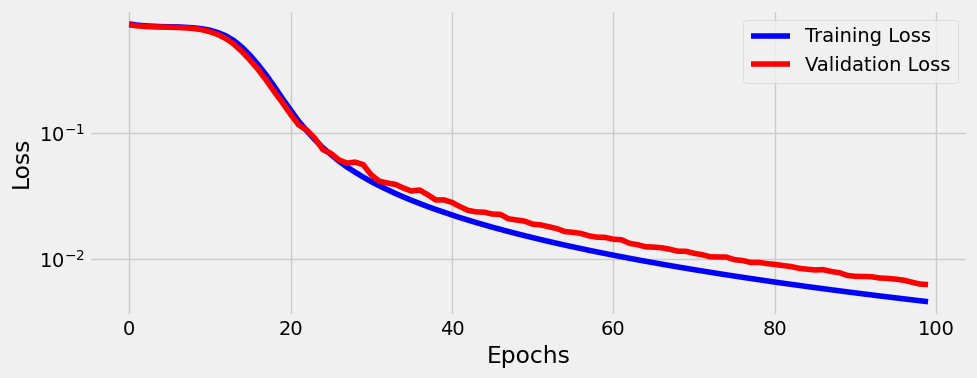

In [41]:
fig = sbs_gru.plot_losses()

In [33]:
StepByStep.loader_apply(test_loader, sbs_gru.correct)

tensor([[57, 57],
        [71, 71]])

## Visualizing the Model

### Hidden States

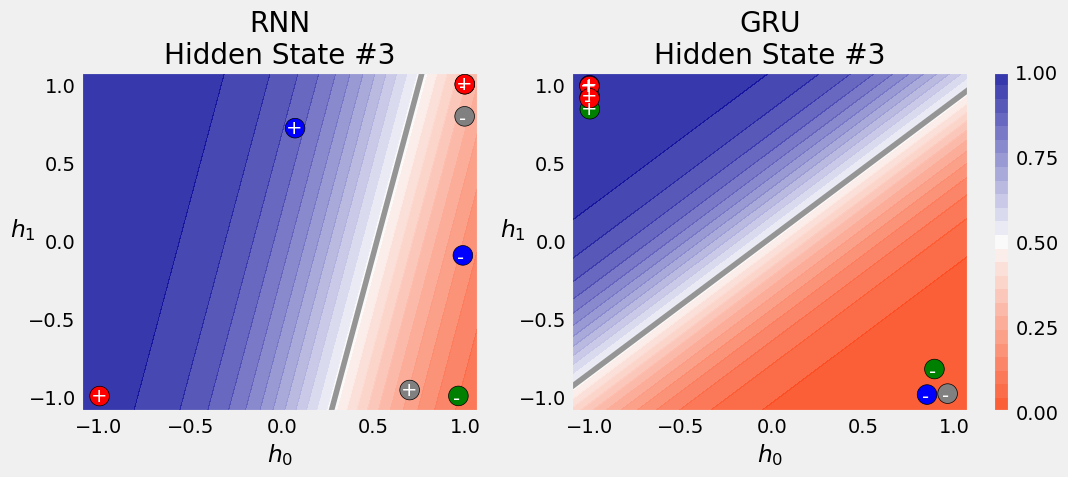

In [42]:
fig = figure20(sbs_rnn.model, sbs_gru.model)

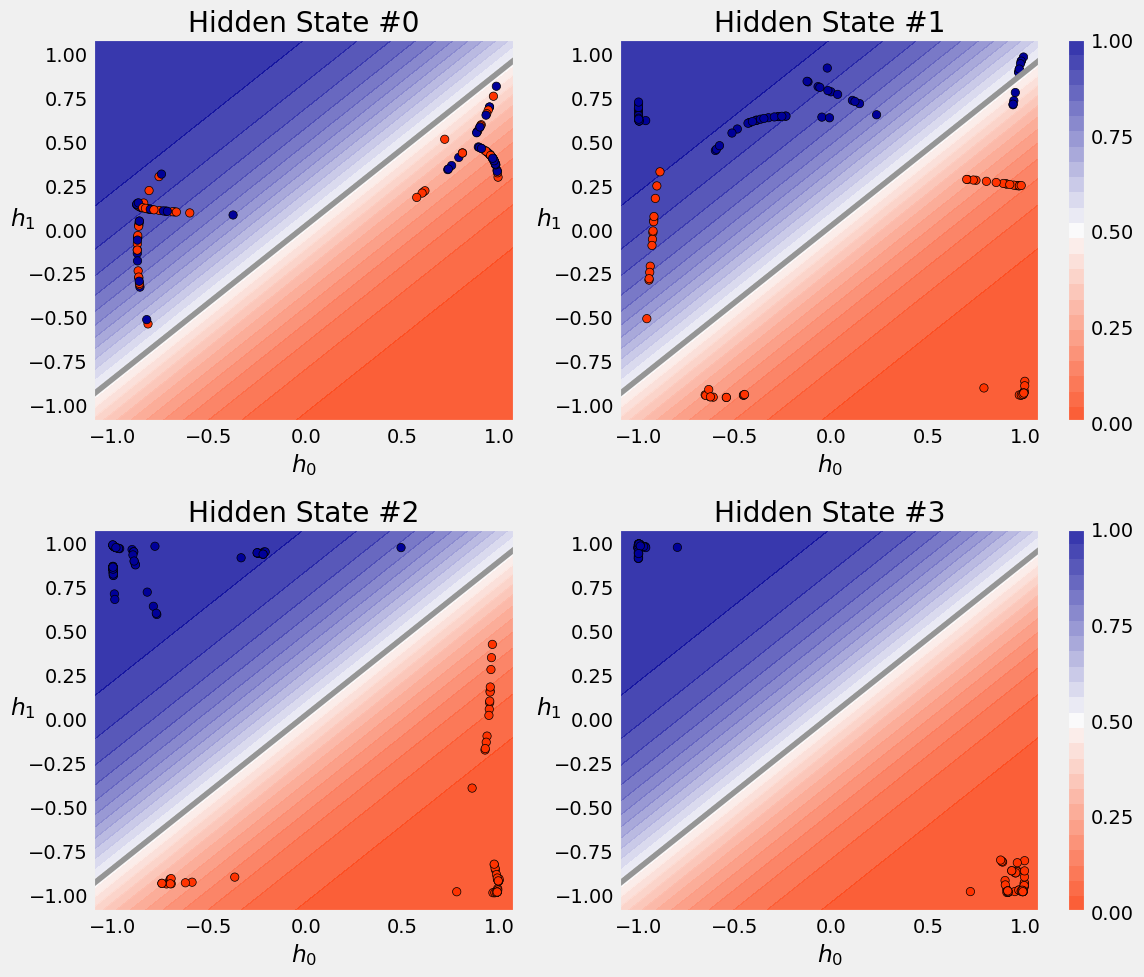

In [43]:
fig = hidden_states_contour(model, points, directions)

### Journey of a GATED Hidden State

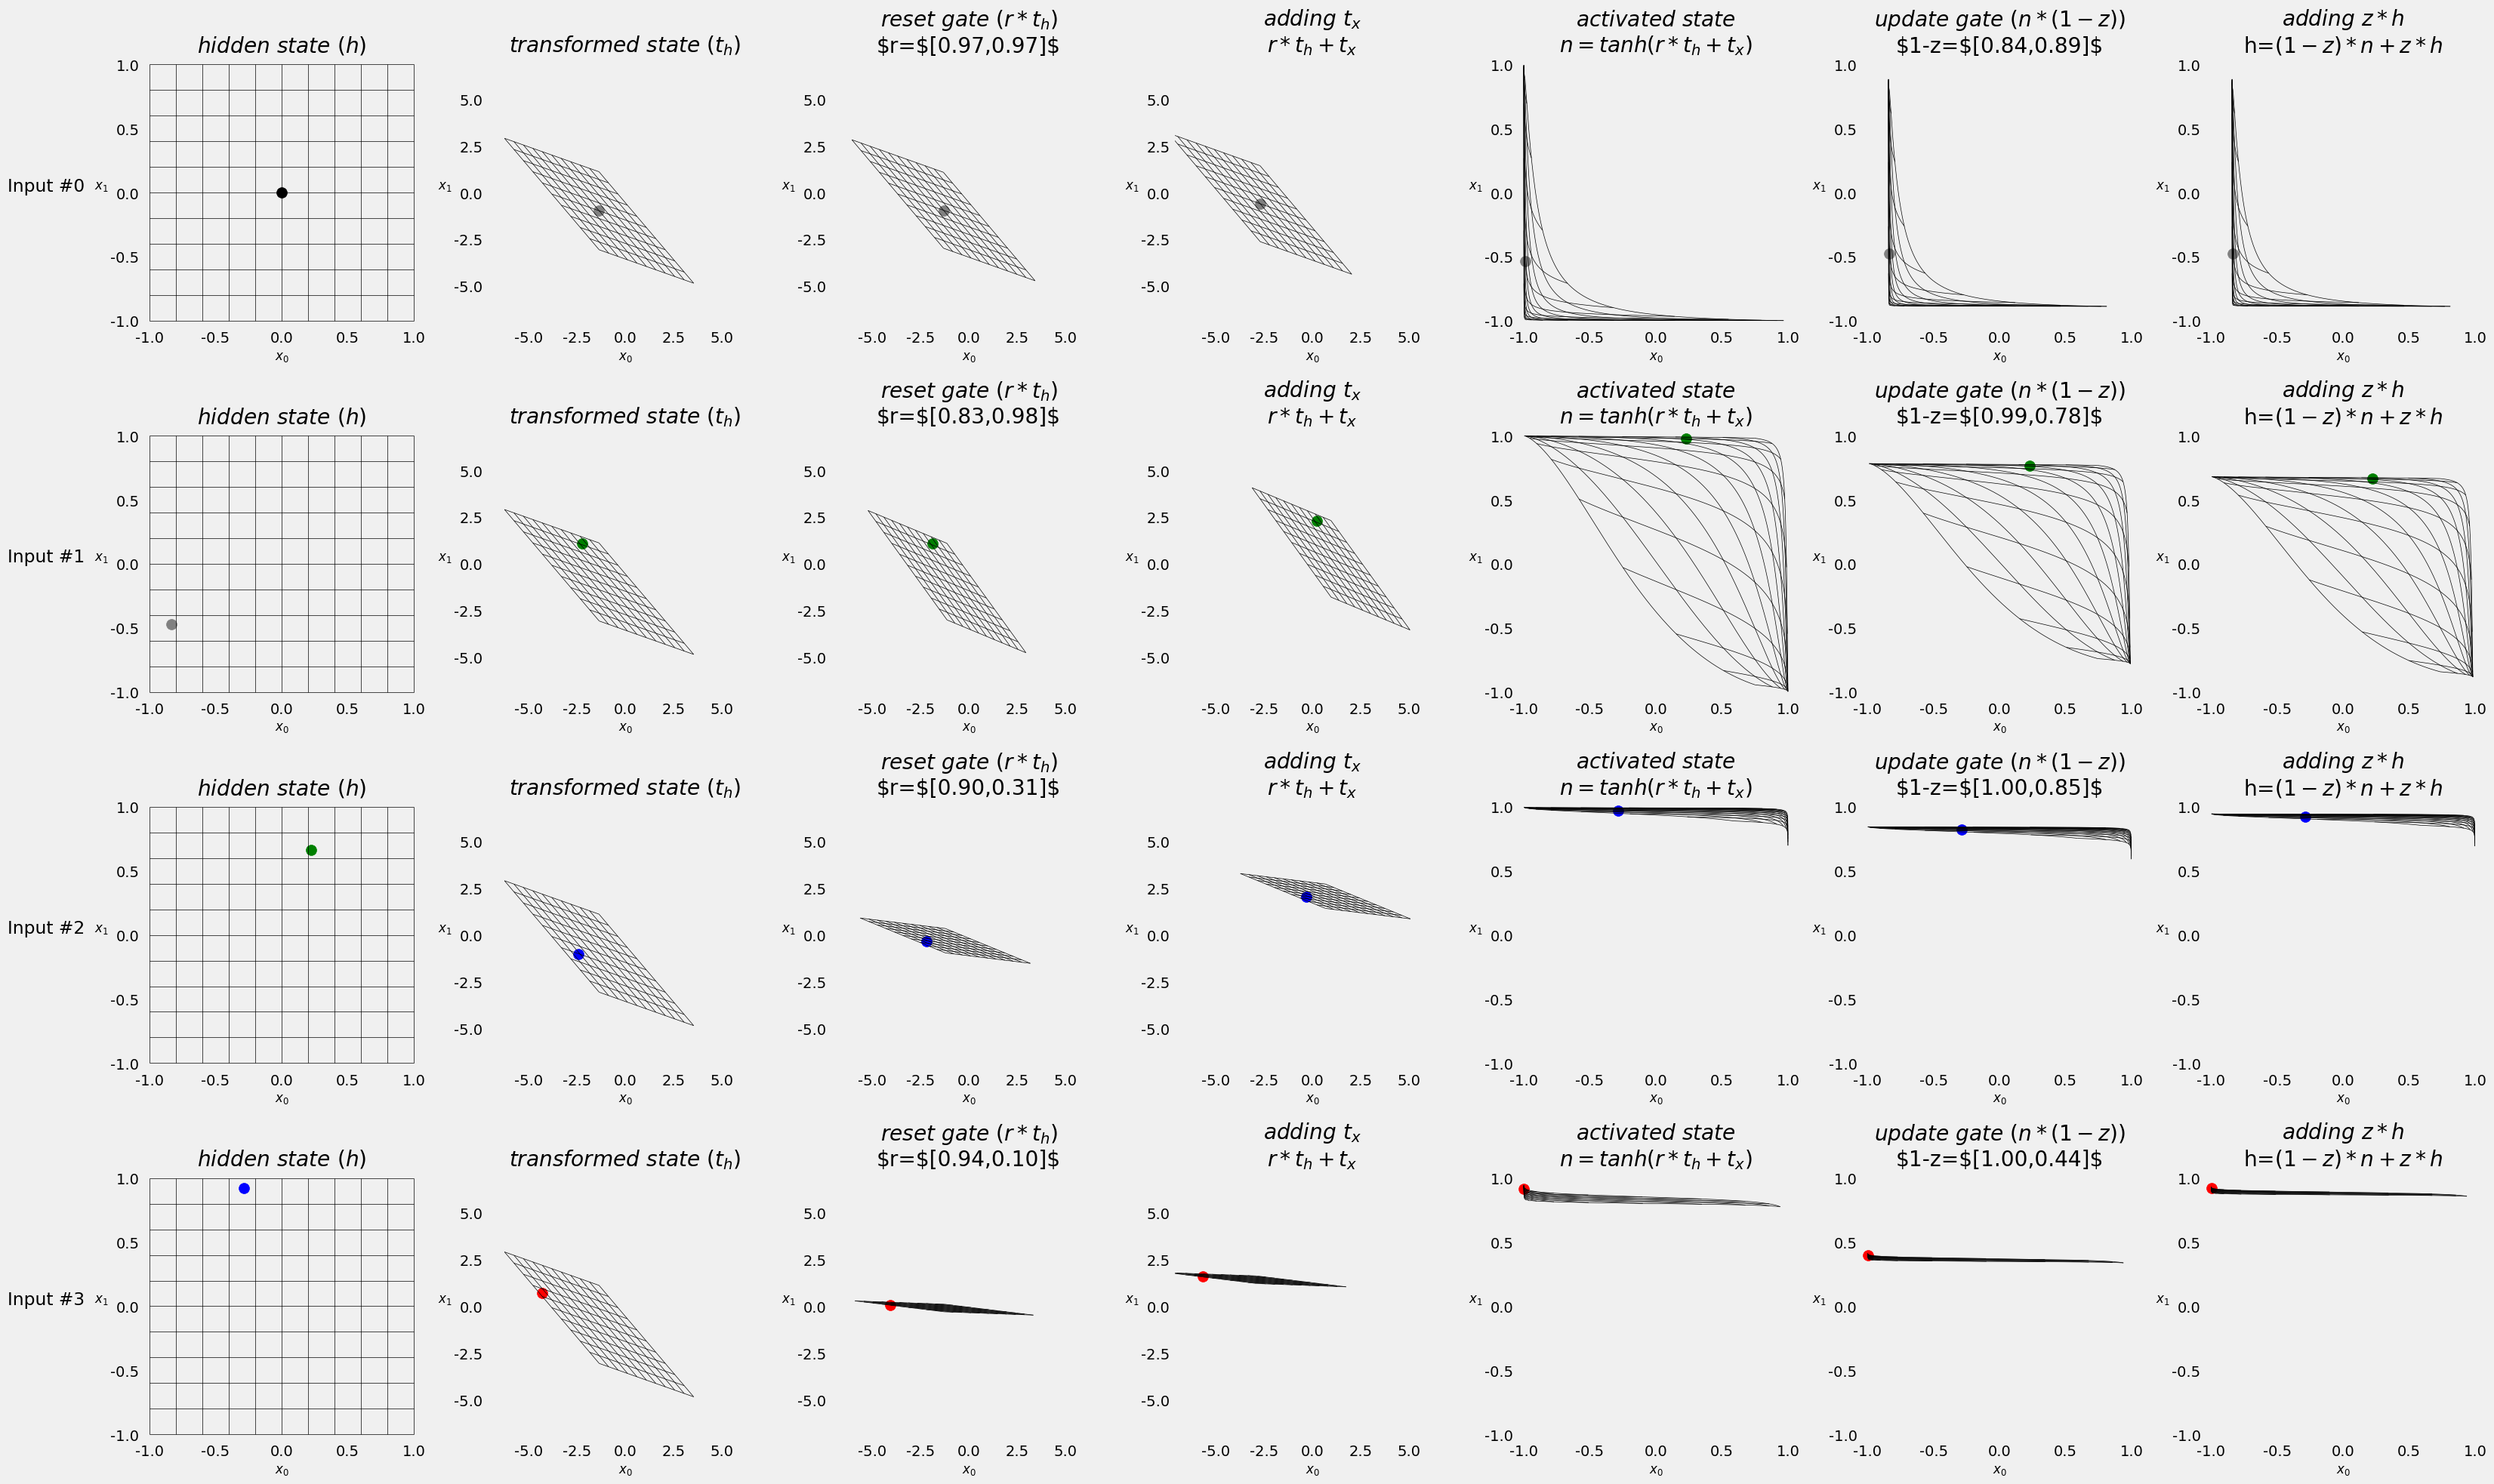

In [45]:
fig = figure22(model.basic_rnn)

## Long Short-Term Memory (LSTM)

$$
\Large
g = \text{tanh}(t_{hg}+t_{xg})
$$

$$
\Large
c' = g * i + c * f
$$

$$
\Large
h' = \text{tanh}(c') * o
$$

### LSTM Cell

$$
\Large
\begin{array}{rclll}
\text{RNN}: h'& = &\text{tanh}(t_h+t_x)
\\
\text{GRU}: h' & = & \text{tanh}(r*t_{hn}+t_{xn}) & * & (1-z) & + & h*z
\\
\text{LSTM}: c' & = & \underbrace{\text{tanh}(t_{hg}+t_{xg})}_{g} & * & \color{#82b366}{i} & + & \color{gray}{c}*\color{red}{f}
\\
h' & = & \text{tanh}(c') & * & \color{#0066cc}{o}
\end{array}
$$

$$
\Large
\begin{array}{rcl}
\color{#82b366}{i\text{(nput gate)}} & \color{#82b366}{=} & \color{#82b366}{\sigma(t_{hi}+t_{xi})}
\\
\color{red}{f\text{(orget gate)}} & \color{red}{=} & \color{red}{\sigma(t_{hf}+t_{xf})}
\\
\color{#0066cc}{o\text{(utput gate)}} & \color{#0066cc}{=} & \color{#0066cc}{\sigma(t_{ho}+t_{xo})}
\\
g & = & \text{tanh}(t_{hg}+t_{xg})
\end{array}
$$

$$
\Large
\begin{array}{rclclcl}
\color{#82b366}{i\ \text{(hidden)}} & \color{#82b366}{:} & \color{#82b366}{t_{hi}} & \color{#82b366}{=} & \color{#82b366}{W_{hi}} \ \color{#82b366}{h} & \color{#82b366}{+} & \color{#82b366}{b_{hi}}
\\
\color{#82b366}{i\ \text{(input)}} & \color{#82b366}{:} & \color{#82b366}{t_{xi}} & \color{#82b366}{=} & \color{#82b366}{W_{ii}} \ \color{#82b366}{x} & \color{#82b366}{+} & \color{#82b366}{b_{ii}}
\\
\color{red}{f\ \text{(hidden)}} & \color{red}{:} & \color{red}{t_{hf}} & \color{red}{=} & \color{red}{W_{hf}} \ \color{red}{h} & \color{red}{+} & \color{red}{b_{hf}}
\\
\color{red}{f\ \text{(input)}} & \color{red}{:} & \color{red}{t_{xf}} & \color{red}{=} & \color{red}{W_{if}} \ \color{red}{x} & \color{red}{+} & \color{red}{b_{if}}
\\
g\ \text{(hidden)} & : & t_{hg} & = & W_{hg} \ h & + & b_{hg}
\\
g\ \text{(input)} & : & t_{xg} & = & W_{ig} \ x & + & b_{ig}
\\
\color{#0066cc}{o\ \text{(hidden)}} & \color{#0066cc}{:} & \color{#0066cc}{t_{ho}} & \color{#0066cc}{=} & \color{#0066cc}{W_{ho}} \ \color{#0066cc}{h} & \color{#0066cc}{+} & \color{#0066cc}{b_{ho}}
\\
\color{#0066cc}{o\ \text{(input)}} & \color{#0066cc}{:} & \color{#0066cc}{t_{xo}} & \color{#0066cc}{=} & \color{#0066cc}{W_{io}} \ \color{#0066cc}{x} & \color{#0066cc}{+} & \color{#0066cc}{b_{io}}
\end{array}
$$

<img src="images/lstm_cell.png" width="60%" height="60%">

In [4]:
n_features = 2
hidden_dim = 2

torch.manual_seed(17)
lstm_cell = nn.LSTMCell(input_size=n_features, hidden_size=hidden_dim)
lstm_state = lstm_cell.state_dict()
lstm_state

OrderedDict([('weight_ih',
              tensor([[-0.0930,  0.0497],
                      [ 0.4670, -0.5319],
                      [-0.6656,  0.0699],
                      [-0.1662,  0.0654],
                      [-0.0449, -0.6828],
                      [-0.6769, -0.1889],
                      [-0.4167, -0.4352],
                      [-0.2060, -0.3989]])),
             ('weight_hh',
              tensor([[-0.7070, -0.5083],
                      [ 0.1418,  0.0930],
                      [-0.5729, -0.5700],
                      [-0.1818, -0.6691],
                      [-0.4316,  0.4019],
                      [ 0.1222, -0.4647],
                      [-0.5578,  0.4493],
                      [-0.6800,  0.4422]])),
             ('bias_ih',
              tensor([-0.3559, -0.0279,  0.6553,  0.2918,  0.4007,  0.3262, -0.0778, -0.3002])),
             ('bias_hh',
              tensor([-0.3991, -0.3200,  0.3483, -0.2604, -0.1582,  0.5558,  0.5761, -0.3919]))])

In [6]:
Wx, bx = lstm_state['weight_ih'], lstm_state['bias_ih']
Wh, bh = lstm_state['weight_hh'], lstm_state['bias_hh']

# Split weights and biases for data points
W_xi, W_xf, W_xg, W_xo = Wx.split(hidden_dim, dim=0)
b_xi, b_xf, b_xg, b_xo = bx.split(hidden_dim, dim=0)

# Split weights and biases for hidden state
W_hi, W_hf, W_hg, W_ho = Wh.split(hidden_dim, dim=0)
b_hi, b_hf, b_hg, b_ho = bh.split(hidden_dim, dim=0)

# Create linear layers for the components
i_input, i_hidden = linear_layers(W_xi, b_xi, W_hi, b_hi)  # input gate - green
f_input, f_hidden = linear_layers(W_xf, b_xf, W_hf, b_hf)  # forget gate - red
o_input, o_hidden = linear_layers(W_xo, b_xo, W_ho, b_ho)  # output gate - blue

In [16]:
g_cell = nn.RNNCell(n_features, hidden_dim)  # black
g_cell.load_state_dict({'weight_ih': W_xg, 'bias_ih': b_xg,
                        'weight_hh': W_hg, 'bias_hh': b_hg})

<All keys matched successfully>

In [9]:
def forget_gate(h, x):
    t_hf = f_hidden(h)
    t_xf = f_input(x)
    f = torch.sigmoid(t_hf + t_xf)
    return f  # red
    
def output_gate(h, x):
    t_ho = o_hidden(h)
    t_xo = o_input(x)
    o = torch.sigmoid(t_ho + t_xo)
    return o  # blue

def input_gate(h, x):
    t_hi = i_hidden(h)
    t_xi = i_input(x)
    i = torch.sigmoid(t_hi + t_xi)
    return i  # green

In [12]:
initial_hidden = torch.zeros(1, hidden_dim)
initial_cell = torch.zeros(1, hidden_dim)

x = torch.as_tensor(points[0]).float()
first_corner = x[0:1]

In [17]:
g = g_cell(first_corner)
i = input_gate(initial_hidden, first_corner)
gated_input = g * i
gated_input

tensor([[0.1832, 0.1548]], grad_fn=<MulBackward0>)

In [18]:
f = forget_gate(initial_hidden, first_corner)
gated_cell = initial_cell * f
gated_cell

tensor([[0., 0.]], grad_fn=<MulBackward0>)

In [19]:
c_prime = gated_cell + gated_input
c_prime

tensor([[0.1832, 0.1548]], grad_fn=<AddBackward0>)

In [20]:
o = output_gate(initial_hidden, first_corner)
h_prime = o * torch.tanh(c_prime)
h_prime

tensor([[0.1070, 0.0542]], grad_fn=<MulBackward0>)

In [21]:
(h_prime, c_prime)

(tensor([[0.1070, 0.0542]], grad_fn=<MulBackward0>),
 tensor([[0.1832, 0.1548]], grad_fn=<AddBackward0>))

In [22]:
lstm_cell(first_corner)

(tensor([[0.1070, 0.0542]], grad_fn=<MulBackward0>),
 tensor([[0.1832, 0.1548]], grad_fn=<AddBackward0>))

## LSTM Layer

## Square Model III: The Sorcerer

### Model Configuration

In [23]:
class SquareModelLSTM(nn.Module):
    def __init__(self, n_inputs, hidden_dim, n_outputs):
        super(SquareModelLSTM, self).__init__()
        self.n_inputs = n_inputs
        self.hidden_dim = hidden_dim
        self.n_outputs = n_outputs
        self.hidden = None
        self.cell = None
        # Simple LSTM
        self.basic_rnn = nn.LSTM(self.n_inputs, self.hidden_dim, batch_first=True) 
        # Classifier to produce as many logits as outputs        
        self.classifier = nn.Linear(self.hidden_dim, self.n_outputs)

    def forward(self, X):
        # X is batch first (N, L, F)
        # output is (N, L, H)
        # final hidden state is (1, N, H)
        # final cell state is (1, N, H)
        batch_first_output, (self.hidden, self.cell) = self.basic_rnn(X)

        # only last item in sequence (N, 1, H)
        last_output = batch_first_output[:, -1]
        # classifier will output (N, 1, n_outputs)
        out = self.classifier(last_output)

        # final output is (N, n_outputs)
        return out.view(-1, self.n_outputs)

### Model Configuration & Training

In [39]:
torch.manual_seed(21)
model = SquareModelLSTM(n_inputs=2, hidden_dim=2, n_outputs=1)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

sbs_lstm = StepByStep(model, loss_fn, optimizer)
sbs_lstm.set_loaders(train_loader, test_loader)
sbs_lstm.train(100)

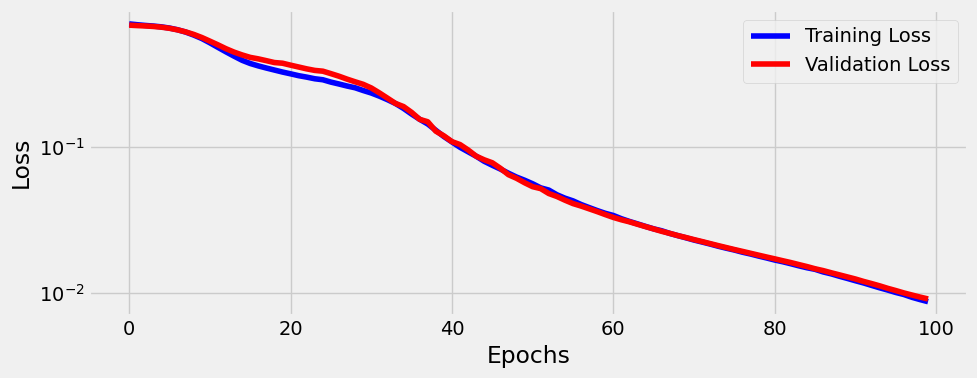

In [30]:
fig = sbs_lstm.plot_losses()

In [31]:
StepByStep.loader_apply(test_loader, sbs_lstm.correct)

tensor([[57, 57],
        [71, 71]])

## Visualizing the Hidden States

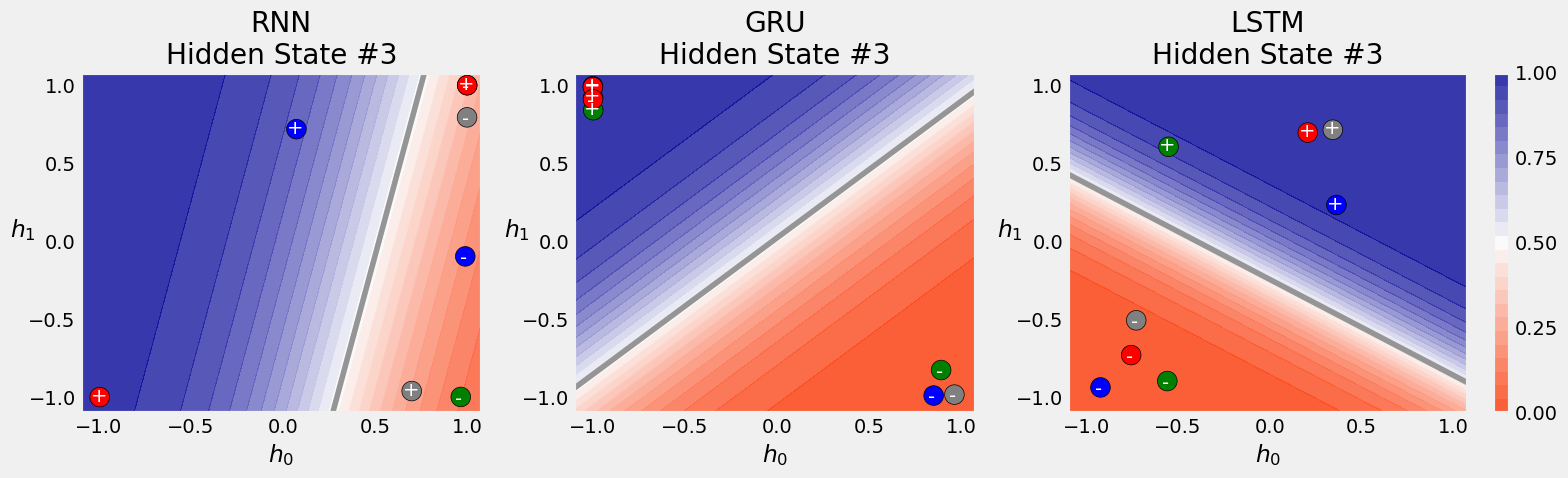

In [40]:
fig = figure25(sbs_rnn.model, sbs_gru.model, sbs_lstm.model)

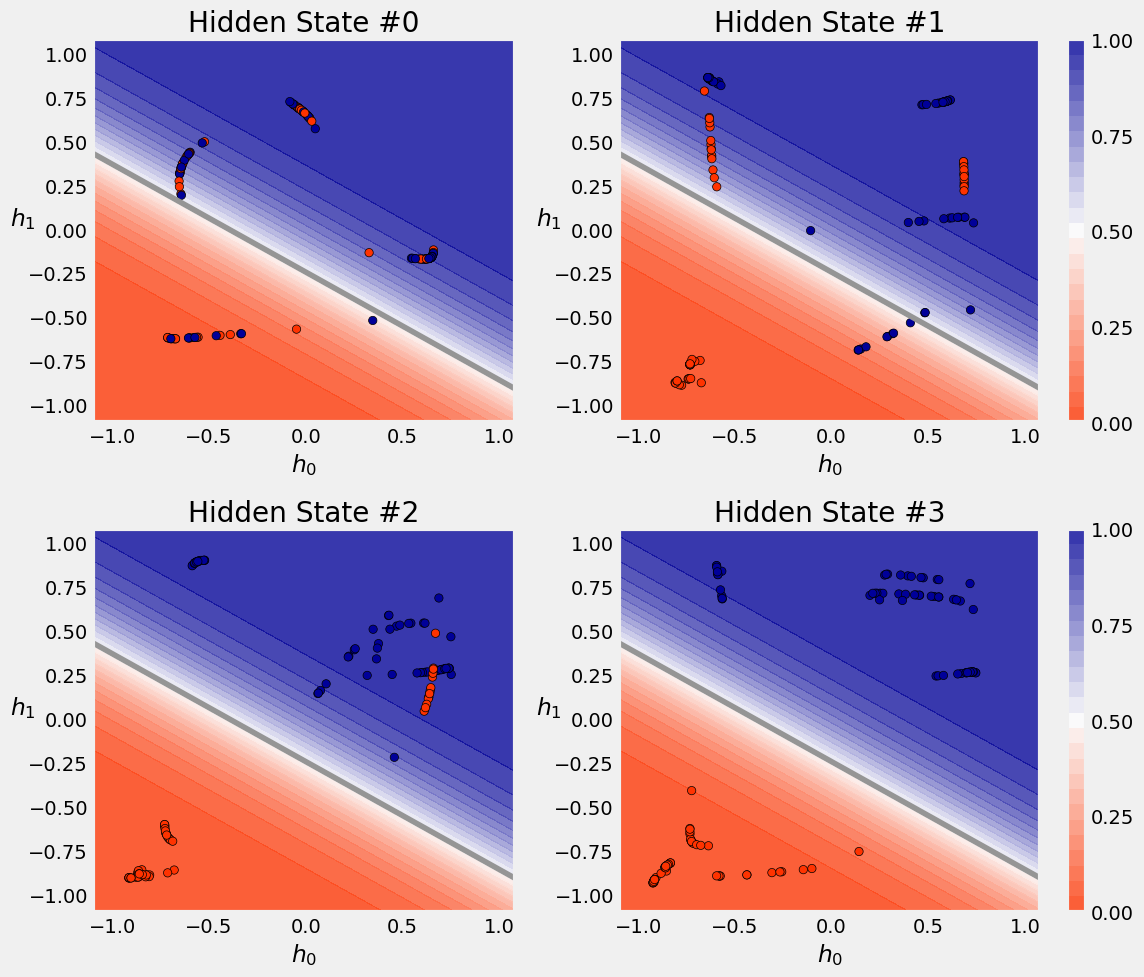

In [41]:
fig = hidden_states_contour(model, points, directions)

## Variable-Length Sequences

In [42]:
s0 = points[0]      # 4 data points
s1 = points[1][2:]  # 2 data points
s2 = points[2][1:]  # 3 data points

s0.shape, s1.shape, s2.shape

((4, 2), (2, 2), (3, 2))

### Padding

In [43]:
all_seqs = [s0, s1, s2]
torch.as_tensor(all_seqs)

ValueError: expected sequence of length 4 at dim 1 (got 2)

In [45]:
seq_tensors = [torch.as_tensor(seq).float() for seq in all_seqs]
padded = rnn_utils.pad_sequence(seq_tensors, batch_first=True)
padded

tensor([[[ 1.1767, -0.8233],
         [-0.8233, -0.8233],
         [-0.8233,  1.1767],
         [ 1.1767,  1.1767]],

        [[-0.3331,  1.6669],
         [ 1.6669,  1.6669],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000]],

        [[-0.6587,  1.3413],
         [-0.6587, -0.6587],
         [ 1.3413, -0.6587],
         [ 0.0000,  0.0000]]])

In [46]:
torch.manual_seed(11)
rnn = nn.RNN(2, 2, batch_first=True)

In [47]:
output_padded, hidden_padded = rnn(padded)
output_padded

tensor([[[-0.6599,  0.9755],
         [ 0.3704,  0.2268],
         [ 0.2619, -0.1903],
         [-0.6919,  0.8826]],

        [[-0.0903, -0.0102],
         [-0.7993,  0.8760],
         [-0.0791,  0.4186],
         [-0.1184,  0.6475]],

        [[ 0.0771, -0.0810],
         [ 0.1019,  0.7203],
         [-0.5837,  0.9530],
         [-0.0326,  0.4061]]], grad_fn=<TransposeBackward1>)

In [48]:
hidden_padded.permute(1, 0, 2)

tensor([[[-0.6919,  0.8826]],

        [[-0.1184,  0.6475]],

        [[-0.0326,  0.4061]]], grad_fn=<PermuteBackward0>)

### Packing

In [49]:
packed = rnn_utils.pack_sequence(seq_tensors, enforce_sorted=False)
packed

PackedSequence(data=tensor([[ 1.1767, -0.8233],
        [-0.6587,  1.3413],
        [-0.3331,  1.6669],
        [-0.8233, -0.8233],
        [-0.6587, -0.6587],
        [ 1.6669,  1.6669],
        [-0.8233,  1.1767],
        [ 1.3413, -0.6587],
        [ 1.1767,  1.1767]]), batch_sizes=tensor([3, 3, 2, 1]), sorted_indices=tensor([0, 2, 1]), unsorted_indices=tensor([0, 2, 1]))

![](images/packed_seq_inddata.png)

![](images/packed_seq_data.png)

In [50]:
(packed.data[[0, 3, 6, 8]] == seq_tensors[0]).all()

tensor(True)

In [51]:
output_packed, hidden_packed = rnn(packed)
output_packed, hidden_packed

(PackedSequence(data=tensor([[-0.6599,  0.9755],
         [ 0.0771, -0.0810],
         [-0.0903, -0.0102],
         [ 0.3704,  0.2268],
         [ 0.1019,  0.7203],
         [-0.7993,  0.8760],
         [ 0.2619, -0.1903],
         [-0.5837,  0.9530],
         [-0.6919,  0.8826]], grad_fn=<CatBackward0>), batch_sizes=tensor([3, 3, 2, 1]), sorted_indices=tensor([0, 2, 1]), unsorted_indices=tensor([0, 2, 1])),
 tensor([[[-0.6919,  0.8826],
          [-0.7993,  0.8760],
          [-0.5837,  0.9530]]], grad_fn=<IndexSelectBackward0>))

In [52]:
hidden_packed == hidden_padded

tensor([[[ True,  True],
         [False, False],
         [False, False]]])

In [53]:
output_packed.data[[2, 5]] # x1 sequence

tensor([[-0.0903, -0.0102],
        [-0.7993,  0.8760]], grad_fn=<IndexBackward0>)

### Unpacking (to padded)

In [54]:
output_unpacked, seq_sizes = rnn_utils.pad_packed_sequence(output_packed, batch_first=True)
output_unpacked, seq_sizes

(tensor([[[-0.6599,  0.9755],
          [ 0.3704,  0.2268],
          [ 0.2619, -0.1903],
          [-0.6919,  0.8826]],
 
         [[-0.0903, -0.0102],
          [-0.7993,  0.8760],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000]],
 
         [[ 0.0771, -0.0810],
          [ 0.1019,  0.7203],
          [-0.5837,  0.9530],
          [ 0.0000,  0.0000]]], grad_fn=<IndexSelectBackward0>),
 tensor([4, 2, 3]))

In [55]:
output_unpacked[:, -1]

tensor([[-0.6919,  0.8826],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000]], grad_fn=<SelectBackward0>)

In [56]:
seq_idx = torch.arange(seq_sizes.size(0))
output_unpacked[seq_idx, seq_sizes-1]

tensor([[-0.6919,  0.8826],
        [-0.7993,  0.8760],
        [-0.5837,  0.9530]], grad_fn=<IndexBackward0>)

### Packing (from padded)

In [57]:
len_seqs = [len(seq) for seq in all_seqs]
len_seqs

[4, 2, 3]

In [58]:
packed = rnn_utils.pack_padded_sequence(padded, len_seqs, enforce_sorted=False, batch_first=True)
packed

PackedSequence(data=tensor([[ 1.1767, -0.8233],
        [-0.6587,  1.3413],
        [-0.3331,  1.6669],
        [-0.8233, -0.8233],
        [-0.6587, -0.6587],
        [ 1.6669,  1.6669],
        [-0.8233,  1.1767],
        [ 1.3413, -0.6587],
        [ 1.1767,  1.1767]]), batch_sizes=tensor([3, 3, 2, 1]), sorted_indices=tensor([0, 2, 1]), unsorted_indices=tensor([0, 2, 1]))

### Variable-Length Dataset

In [59]:
var_points, var_directions = generate_sequences(variable_len=True)
var_points[:2]

[array([[ 1.73270012, -0.26729988],
        [-0.26729988, -0.26729988],
        [-0.26729988,  1.73270012],
        [ 1.73270012,  1.73270012]]),
 array([[ 1.44822753, -0.55177247],
        [-0.55177247, -0.55177247],
        [-0.55177247,  1.44822753],
        [ 1.44822753,  1.44822753]])]

## Data Preparation

In [61]:
class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = [torch.as_tensor(s).float() for s in x]
        self.y = torch.as_tensor(y).float().view(-1, 1)
        
    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)
    
train_var_data = CustomDataset(var_points, var_directions)

In [62]:
train_var_loader = DataLoader(train_var_data, batch_size=16, shuffle=True)
next(iter(train_var_loader))

RuntimeError: stack expects each tensor to be equal size, but got [3, 2] at entry 0 and [2, 2] at entry 1

### Collate Function

In [63]:
def pack_collate(batch):
    X = [item[0] for item in batch]
    y = [item[1] for item in batch]
    X_pack = rnn_utils.pack_sequence(X, enforce_sorted=False)

    return X_pack, torch.as_tensor(y).view(-1, 1)

In [64]:
# list of tuples returned by the dataset
dummy_batch = [train_var_data[0], train_var_data[1]]
dummy_x, dummy_y = pack_collate(dummy_batch)
dummy_x

PackedSequence(data=tensor([[ 1.7327, -0.2673],
        [ 1.4482, -0.5518],
        [-0.2673, -0.2673],
        [-0.5518, -0.5518],
        [-0.2673,  1.7327],
        [-0.5518,  1.4482],
        [ 1.7327,  1.7327],
        [ 1.4482,  1.4482]]), batch_sizes=tensor([2, 2, 2, 2]), sorted_indices=tensor([0, 1]), unsorted_indices=tensor([0, 1]))

In [65]:
train_var_loader = DataLoader(train_var_data, batch_size=16, shuffle=True, collate_fn=pack_collate)
x_batch, y_batch = next(iter(train_var_loader))

## Square Model IV: Packed

In [66]:
class SquareModelPacked(nn.Module):
    def __init__(self, n_features, hidden_dim, n_outputs):
        super(SquareModelPacked, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_features = n_features
        self.n_outputs = n_outputs
        self.hidden = None
        self.cell = None
        # Simple LSTM
        self.basic_rnn = nn.LSTM(self.n_features, self.hidden_dim, bidirectional=True) 
        # Classifier to produce as many logits as outputs        
        self.classifier = nn.Linear(2 * self.hidden_dim, self.n_outputs)

    def forward(self, X):       
        # X is a PACKED sequence now

        # output is PACKED
        # final hidden state is (2, N, H) - bidirectional
        # final cell state is (2, N, H) - bidirectional
        rnn_out, (self.hidden, self.cell) = self.basic_rnn(X)
        # unpack the output (N, L, 2*H)
        batch_first_output, seq_sizes = rnn_utils.pad_packed_sequence(rnn_out, batch_first=True)

        # only last item in sequence (N, 1, 2*H)
        seq_idx = torch.arange(seq_sizes.size(0))
        last_output = batch_first_output[seq_idx, seq_sizes-1]
        # classifier will output (N, 1, n_outputs)
        out = self.classifier(last_output)

        # final output is (N, n_outputs)
        return out.view(-1, self.n_outputs)

## Model Configuration & Training

In [67]:
torch.manual_seed(21)
model = SquareModelPacked(n_features=2, hidden_dim=2, n_outputs=1)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

sbs_packed = StepByStep(model, loss_fn, optimizer)
sbs_packed.set_loaders(train_var_loader)
sbs_packed.train(100)

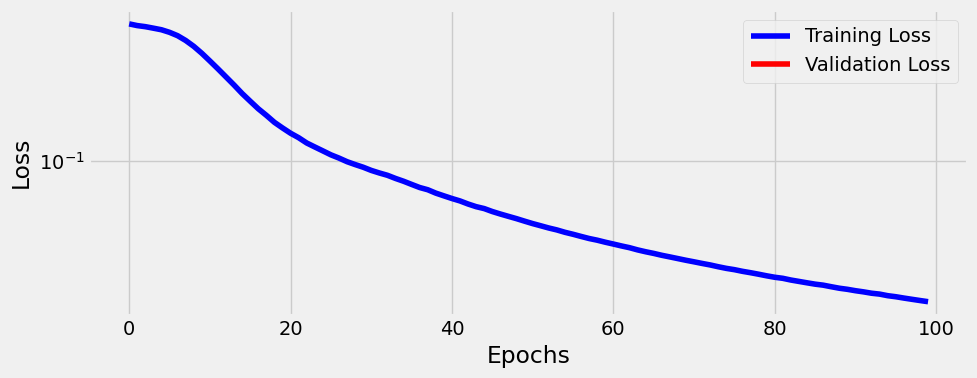

In [68]:
fig = sbs_packed.plot_losses()

In [69]:
StepByStep.loader_apply(train_var_loader, sbs_packed.correct)

tensor([[65, 65],
        [63, 63]])

# 1D Convolutions

In [70]:
temperatures = np.array([5, 11, 15, 6, 5, 3, 3, 0, 0, 3, 4, 2, 1])

![](images/conv1_ma.png)

In [75]:
size = 5
weight = torch.ones(size) * 0.2
F.conv1d(torch.as_tensor(temperatures).float().view(1, 1, -1), weight=weight.view(1, 1, -1))

tensor([[[8.4000, 8.0000, 6.4000, 3.4000, 2.2000, 1.8000, 2.0000, 1.8000,
          2.0000]]])

### Shapes

In [76]:
seqs = torch.as_tensor(points).float() # N, L, F
seqs_length_last = seqs.permute(0, 2, 1) 
seqs_length_last.shape # N, F=C, L

torch.Size([128, 2, 4])

### Multiple Features or Channels

In [77]:
torch.manual_seed(17)
conv_seq = nn.Conv1d(in_channels=2, out_channels=1, kernel_size=2, bias=False)
conv_seq.weight, conv_seq.weight.shape

(Parameter containing:
 tensor([[[-0.0658,  0.0351],
          [ 0.3302, -0.3761]]], requires_grad=True),
 torch.Size([1, 2, 2]))

![](images/conv1d.png)

In [78]:
conv_seq(seqs_length_last[0:1])

tensor([[[-0.0685, -0.6892,  0.0414]]], grad_fn=<ConvolutionBackward0>)

$$
\Large
l_i * f = \frac{(l_i + 2p) - f}{s}+1
$$

### Dilation

![](images/conv1d_dilated.png)

In [79]:
torch.manual_seed(17)
conv_dilated = nn.Conv1d(in_channels=2, out_channels=1, kernel_size=2, dilation=2, bias=False)
conv_dilated.weight, conv_dilated.weight.shape

(Parameter containing:
 tensor([[[-0.0658,  0.0351],
          [ 0.3302, -0.3761]]], requires_grad=True),
 torch.Size([1, 2, 2]))

In [80]:
conv_dilated(seqs_length_last[0:1])

tensor([[[-0.8207, -0.6190]]], grad_fn=<ConvolutionBackward0>)

$$
\Large
l_i * f = \frac{(l_i + 2p) - d(f - 1) - 1}{s}+1
$$

### Data Preparation

In [81]:
train_data = TensorDataset(torch.as_tensor(points).float().permute(0, 2, 1), 
                           torch.as_tensor(directions).view(-1, 1).float())
test_data = TensorDataset(torch.as_tensor(test_points).float().permute(0, 2, 1), 
                          torch.as_tensor(test_directions).view(-1, 1).float())

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16)

### Model Configuration & Training

In [82]:
torch.manual_seed(21)
model = nn.Sequential()
model.add_module('conv1d', nn.Conv1d(2, 1, kernel_size=2))
model.add_module('relu', nn.ReLU())
model.add_module('flatten', nn.Flatten())
model.add_module('output', nn.Linear(3, 1))
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

sbs_conv1 = StepByStep(model, loss_fn, optimizer)
sbs_conv1.set_loaders(train_loader, test_loader)
sbs_conv1.train(100)

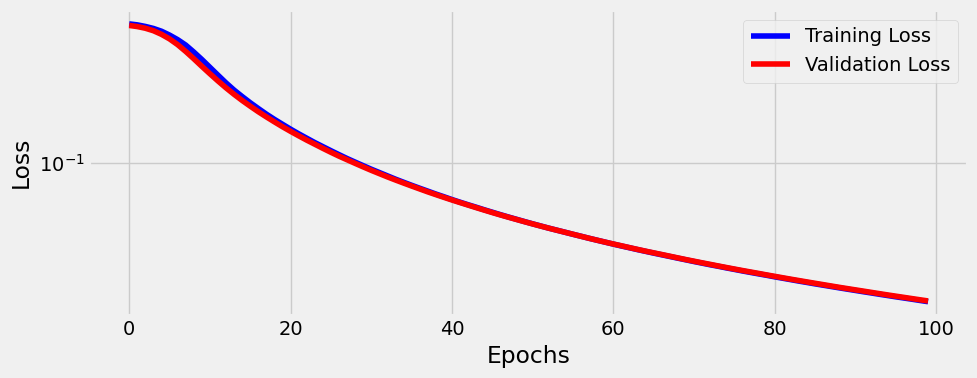

In [83]:
fig = sbs_conv1.plot_losses()

In [84]:
StepByStep.loader_apply(test_loader, sbs_conv1.correct)

tensor([[57, 57],
        [71, 71]])

### Visualizing the Model

In [85]:
model.conv1d.state_dict()

OrderedDict([('weight',
              tensor([[[-1.4728e-03,  2.3287e+00],
                       [-2.3290e+00, -1.1806e-03]]], device='cuda:0')),
             ('bias', tensor([-0.0009], device='cuda:0'))])

![](images/conv1d_edges.png)

$$
\Large
\text{edge feature} = - 0.22\ x_0^{\text{1st}} - 2.38\ x_1^{\text{1st}} + 2.33\ x_0^{\text{2nd}} - 0.18\ x_1^{\text{2nd}} - 0.5457
$$

$$
\Large
\overline{\text{AD}}\ or\ \overline{\text{DC}} \implies x_1^{\text{1st}} \approx -1\ \text{and}\ x_0^{\text{2nd}} \approx 1 \implies \text{edge feature} > 0
$$

## Putting It All Together

### Fixed-Length Dataset

In [86]:
points, directions = generate_sequences(n=128, seed=13)
train_data = TensorDataset(torch.as_tensor(points).float(), 
                           torch.as_tensor(directions).view(-1, 1).float())
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

### Variable-Length Dataset

In [87]:
var_points, var_directions = generate_sequences(variable_len=True)

In [88]:
class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = [torch.as_tensor(s).float() for s in x]
        self.y = torch.as_tensor(y).float().view(-1, 1)
        
    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)
    
train_var_data = CustomDataset(var_points, var_directions)

In [89]:
def pack_collate(batch):
    X = [item[0] for item in batch]
    y = [item[1] for item in batch]
    X_pack = rnn_utils.pack_sequence(X, enforce_sorted=False)

    return X_pack, torch.as_tensor(y).view(-1, 1)

train_var_loader = DataLoader(train_var_data, batch_size=16, shuffle=True, collate_fn=pack_collate)

### There Can Be Only ONE... Model

In [ ]:
class SquareModelOne(nn.Module):
    def __init__(self, n_features, hidden_dim, n_outputs, rnn_layer=nn.LSTM, **kwargs):
        super(SquareModelOne, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_features = n_features
        self.n_outputs = n_outputs
        self.hidden = None
        self.cell = None
        self.basic_rnn = rnn_layer(self.n_features, self.hidden_dim, batch_first=True, **kwargs)
        output_dim = (self.basic_rnn.bidirectional + 1) * self.hidden_dim
        # Classifier to produce as many logits as outputs
        self.classifier = nn.Linear(output_dim, self.n_outputs)

    def forward(self, X):
        is_packed = isinstance(X, nn.utils.rnn.PackedSequence)
        # X is a PACKED sequence, there is no need to permute
        
        rnn_out, self.hidden = self.basic_rnn(X)
        if isinstance(self.basic_rnn, nn.LSTM):
            self.hidden, self.cell = self.hidden

        if is_packed:
            # unpack the output
            batch_first_output, seq_sizes = rnn_utils.pad_packed_sequence(rnn_out, batch_first=True)        
            seq_slice = torch.arange(seq_sizes.size(0))
        else:
            batch_first_output = rnn_out
            seq_sizes = 0 # so it is -1 as the last output
            seq_slice = slice(None, None, None) # same as ':'

        # only last item in sequence (N, 1, H)
        last_output = batch_first_output[seq_slice, seq_sizes-1]

        # classifier will output (N, 1, n_outputs)
        out = self.classifier(last_output)

        # final output is (N, n_outputs)
        return out.view(-1, self.n_outputs)

### Model Configuration & Training

In [91]:
torch.manual_seed(21)
model = SquareModelOne(n_features=2, hidden_dim=2, n_outputs=1,
                       rnn_layer=nn.LSTM, num_layers=1, bidirectional=True)
loss = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [92]:
sbs_one = StepByStep(model, loss, optimizer)
sbs_one.set_loaders(train_var_loader)
sbs_one.train(100)

In [93]:
StepByStep.loader_apply(train_var_loader, sbs_one.correct)

tensor([[65, 65],
        [63, 63]])